In [1]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

seed_number_range = []     
for num in range(1):
    seed_number_range.append(f'Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0]#,5,10,15,20,25,50,100,800,1000,1100,1200,1300,1400,1500]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}

Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

WARNING    <timed exec>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 30.8 s, sys: 9.58 s, total: 40.4 s
Wall time: 47.9 s


# Figure 2 - A

WARNING    <ipython-input-2-405c77e6ef0f>:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
 [py.warnings]
  cbar = plt.colorbar(sm)



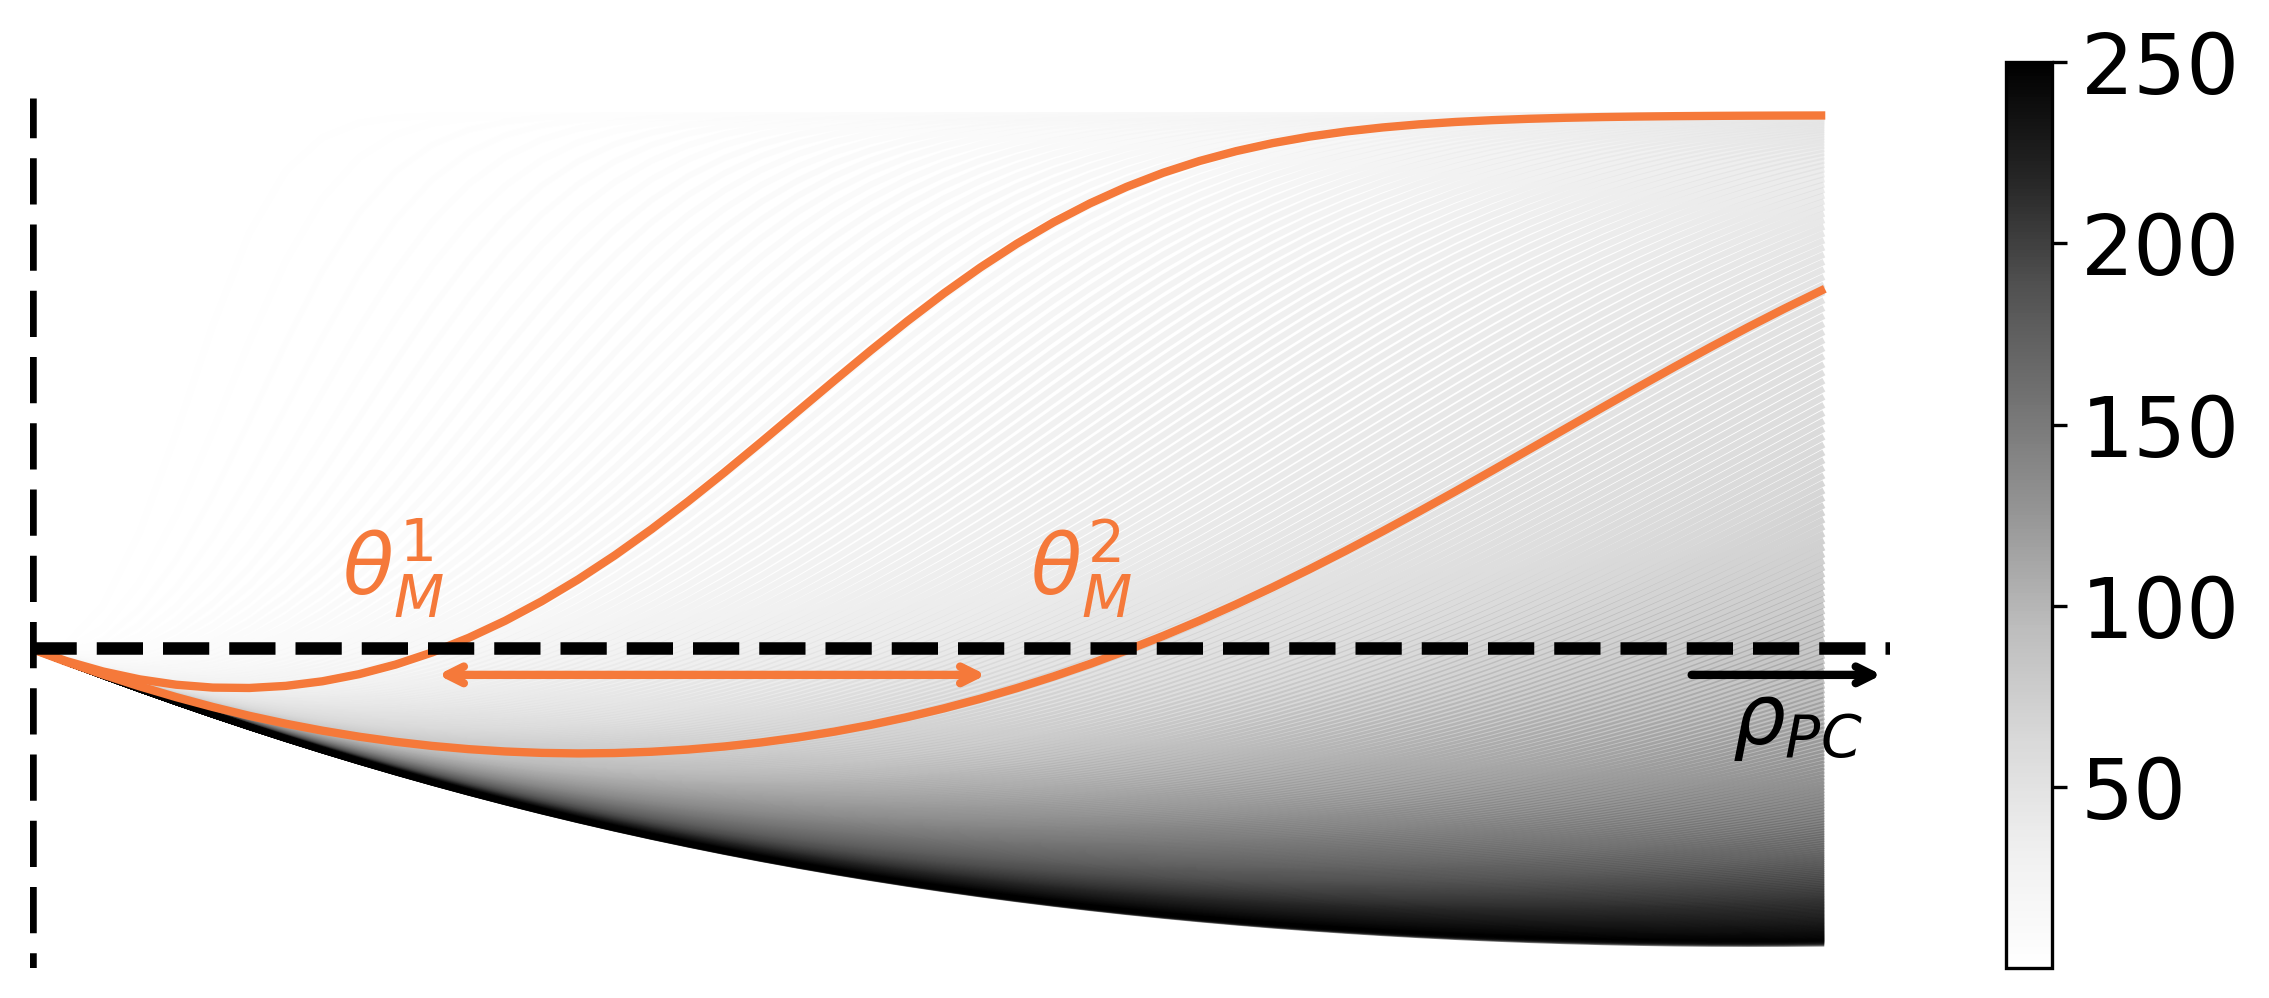

In [2]:
## import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
# Given values
rho, tau = np.linspace(0, 130), 200
theta_values = np.linspace(0.1, 250, 250)
rho_max = 250
cmap = plt.get_cmap('Greys')

# Create a figure
c = 0.01
plt.figure(figsize=(10, 4),dpi=300)


for theta in theta_values:
    w_grad = tanh(c*rho*(rho - theta)/theta)
    line, = plt.plot(rho, w_grad, color=cmap(theta / max(theta_values)), alpha=0.5)

theta_range = [30,80]

for jj,theta in enumerate(theta_range):
    w_grad = tanh(c*rho*(rho - theta)/theta)
    line, = plt.plot(rho, w_grad, color='#F5793A',lw=2)
    plt.text(theta, 0.1, fr'$\theta^{jj+1}_M$', fontsize=20, ha='right',color = '#F5793A')
    
plt.annotate('',xy=(theta_range[1]-10, -0.05),xytext=(theta_range[0]-1, -0.05), horizontalalignment="center",arrowprops=dict(arrowstyle='<->',lw=2,color = '#F5793A'))
# Set labels and title
plt.xlabel('rho')
plt.ylabel('w_grad')

# Show colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(theta_values), vmax=max(theta_values)))
sm.set_array([])
cbar = plt.colorbar(sm)
# cbar.set_label(label=r'$\theta_M$',fontsize=20,rotation=0)
cbar.ax.tick_params(labelsize=20)
plt.xlabel(r'$\rho_{PC}$')
plt.ylabel(r'$\phi\left(\rho_{PC},\theta_M\right)$')
plt.axhline(0, color='k', ls='--', lw=3)
plt.ylim([-0.6, 1.1])
plt.xlim([0, 135])
plt.axvline(0, ymin=-0.3, ymax=.96, color='k', ls='--', lw=3)
plt.axis('off')
plt.text(133, -0.18, r'$\rho_{PC}$', fontsize=20, ha='right')
# plt.text(3, 1.15, r'LTP', fontsize=20, ha='right',va='top',rotation=0)
# plt.text(3, -.65, r'LTD', fontsize=20, ha='right',va='top',rotation=0)
# plt.text(135, -0.2, r'+', fontsize=20, ha='right')
plt.annotate('',xy=(135, -0.05),xytext=(120, -0.05), horizontalalignment="center",arrowprops=dict(arrowstyle='->',lw=2))
plt.show()


# Figure 2 - B

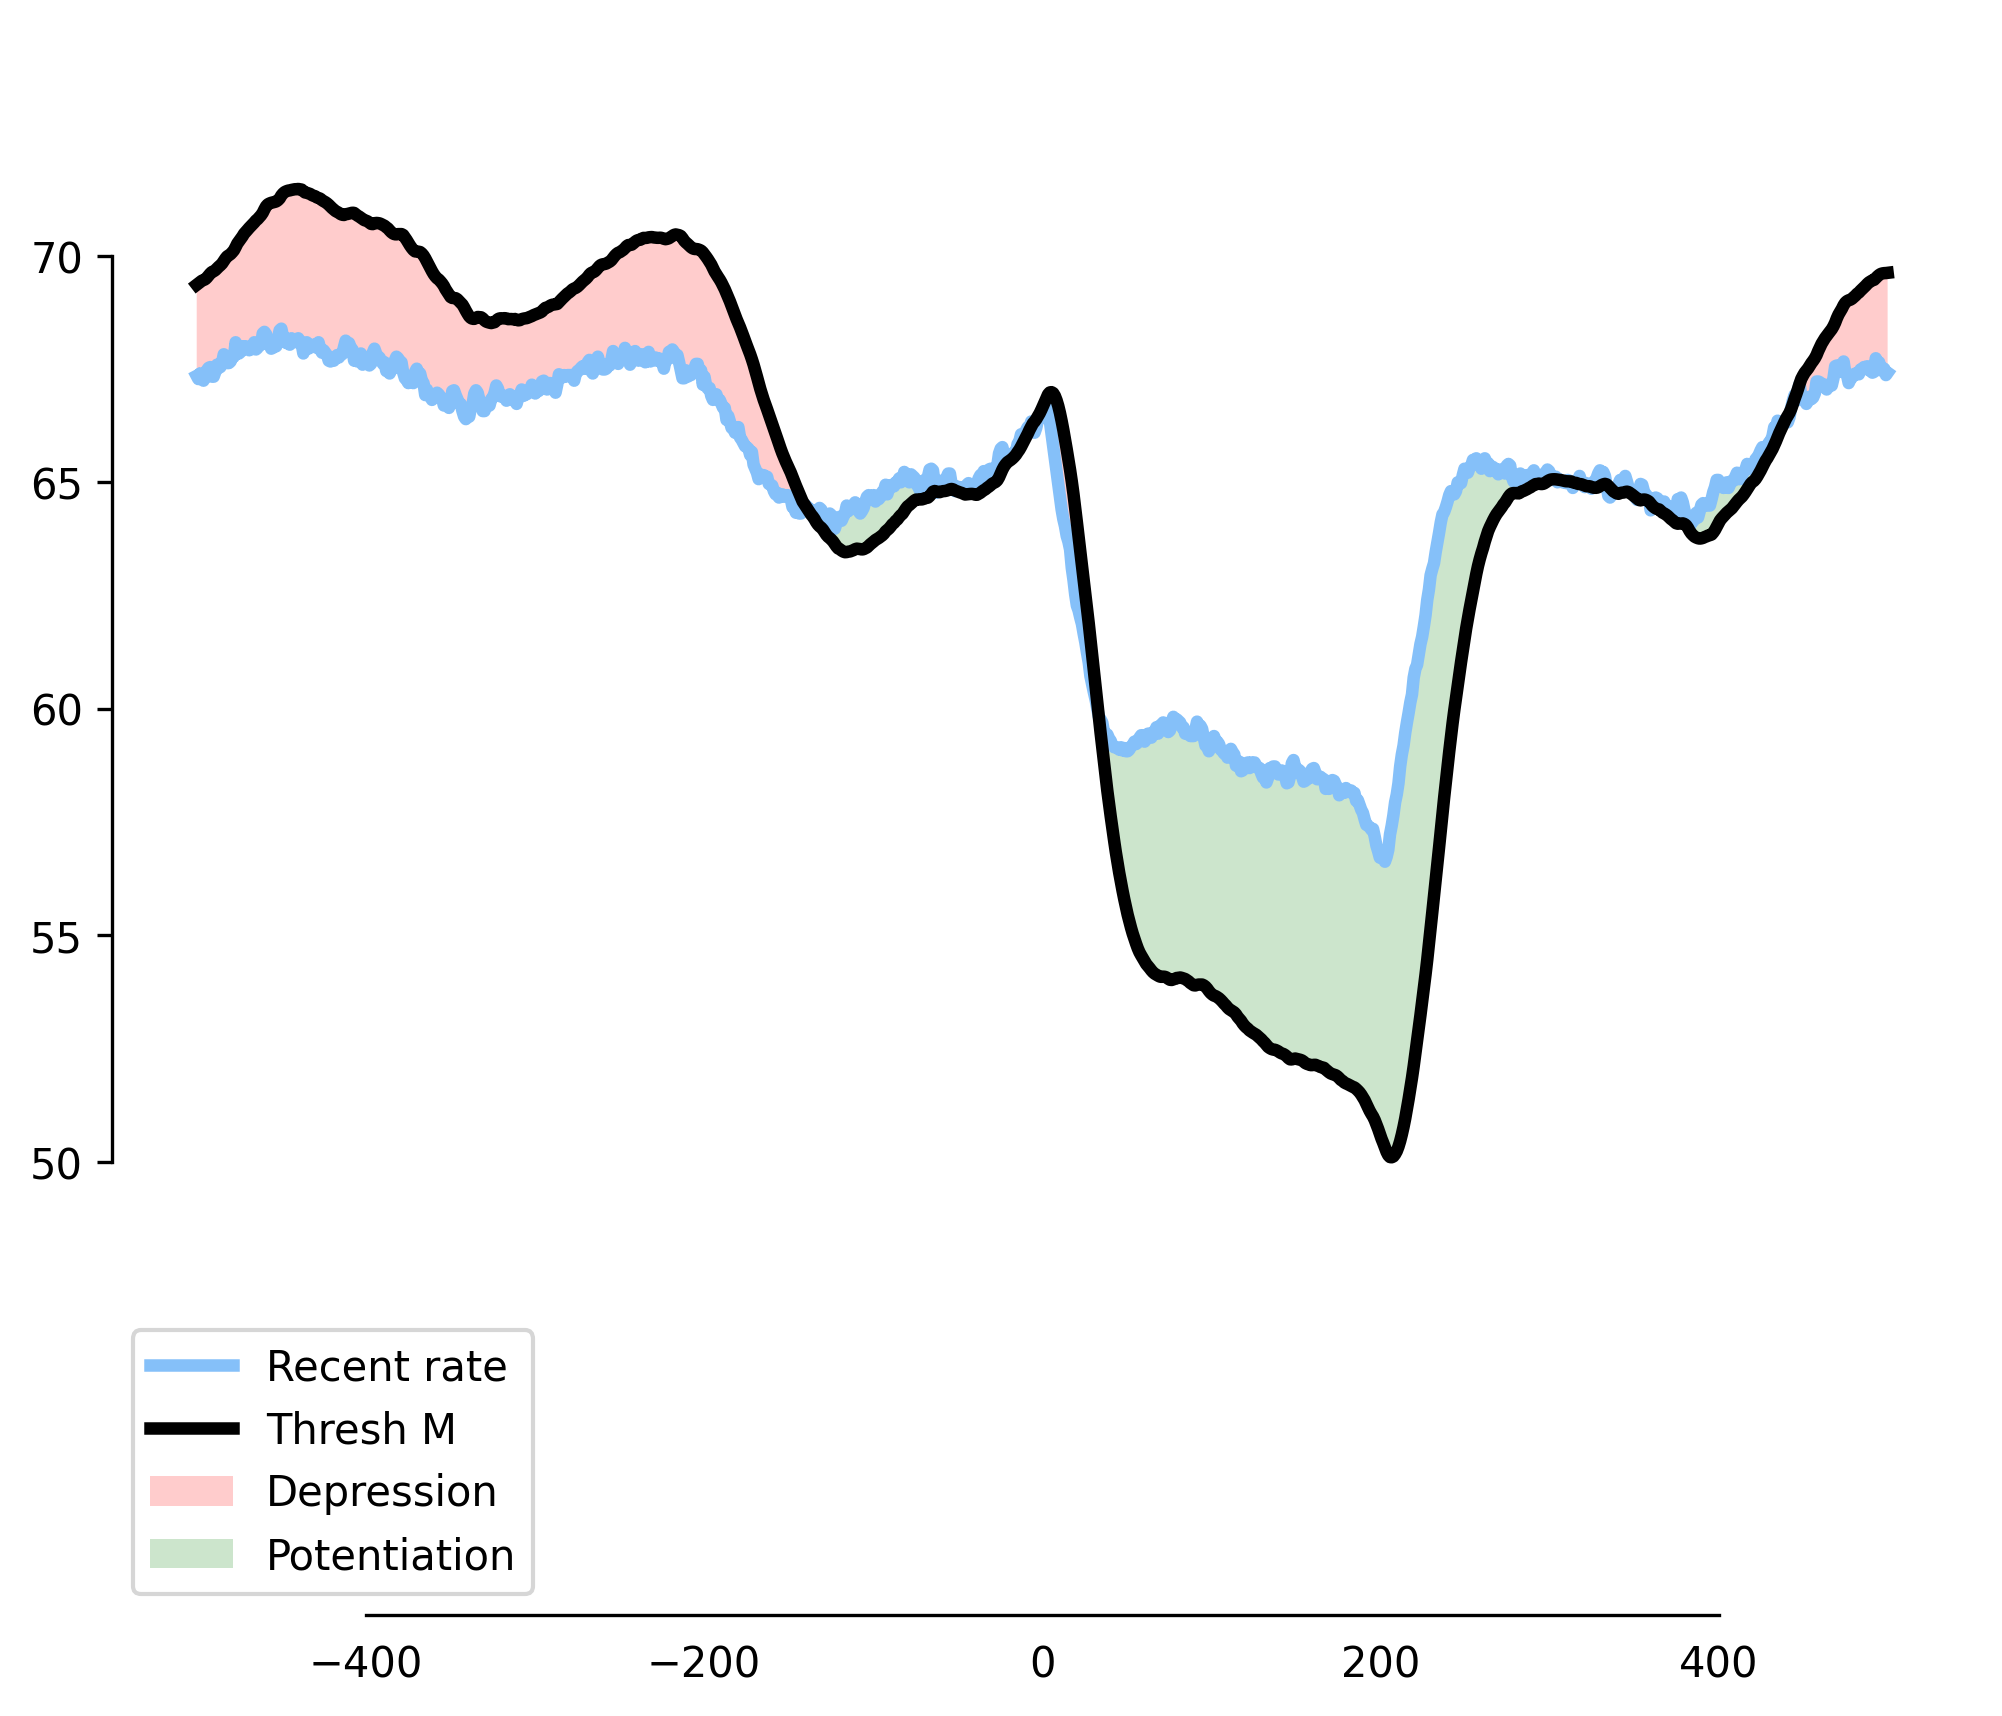

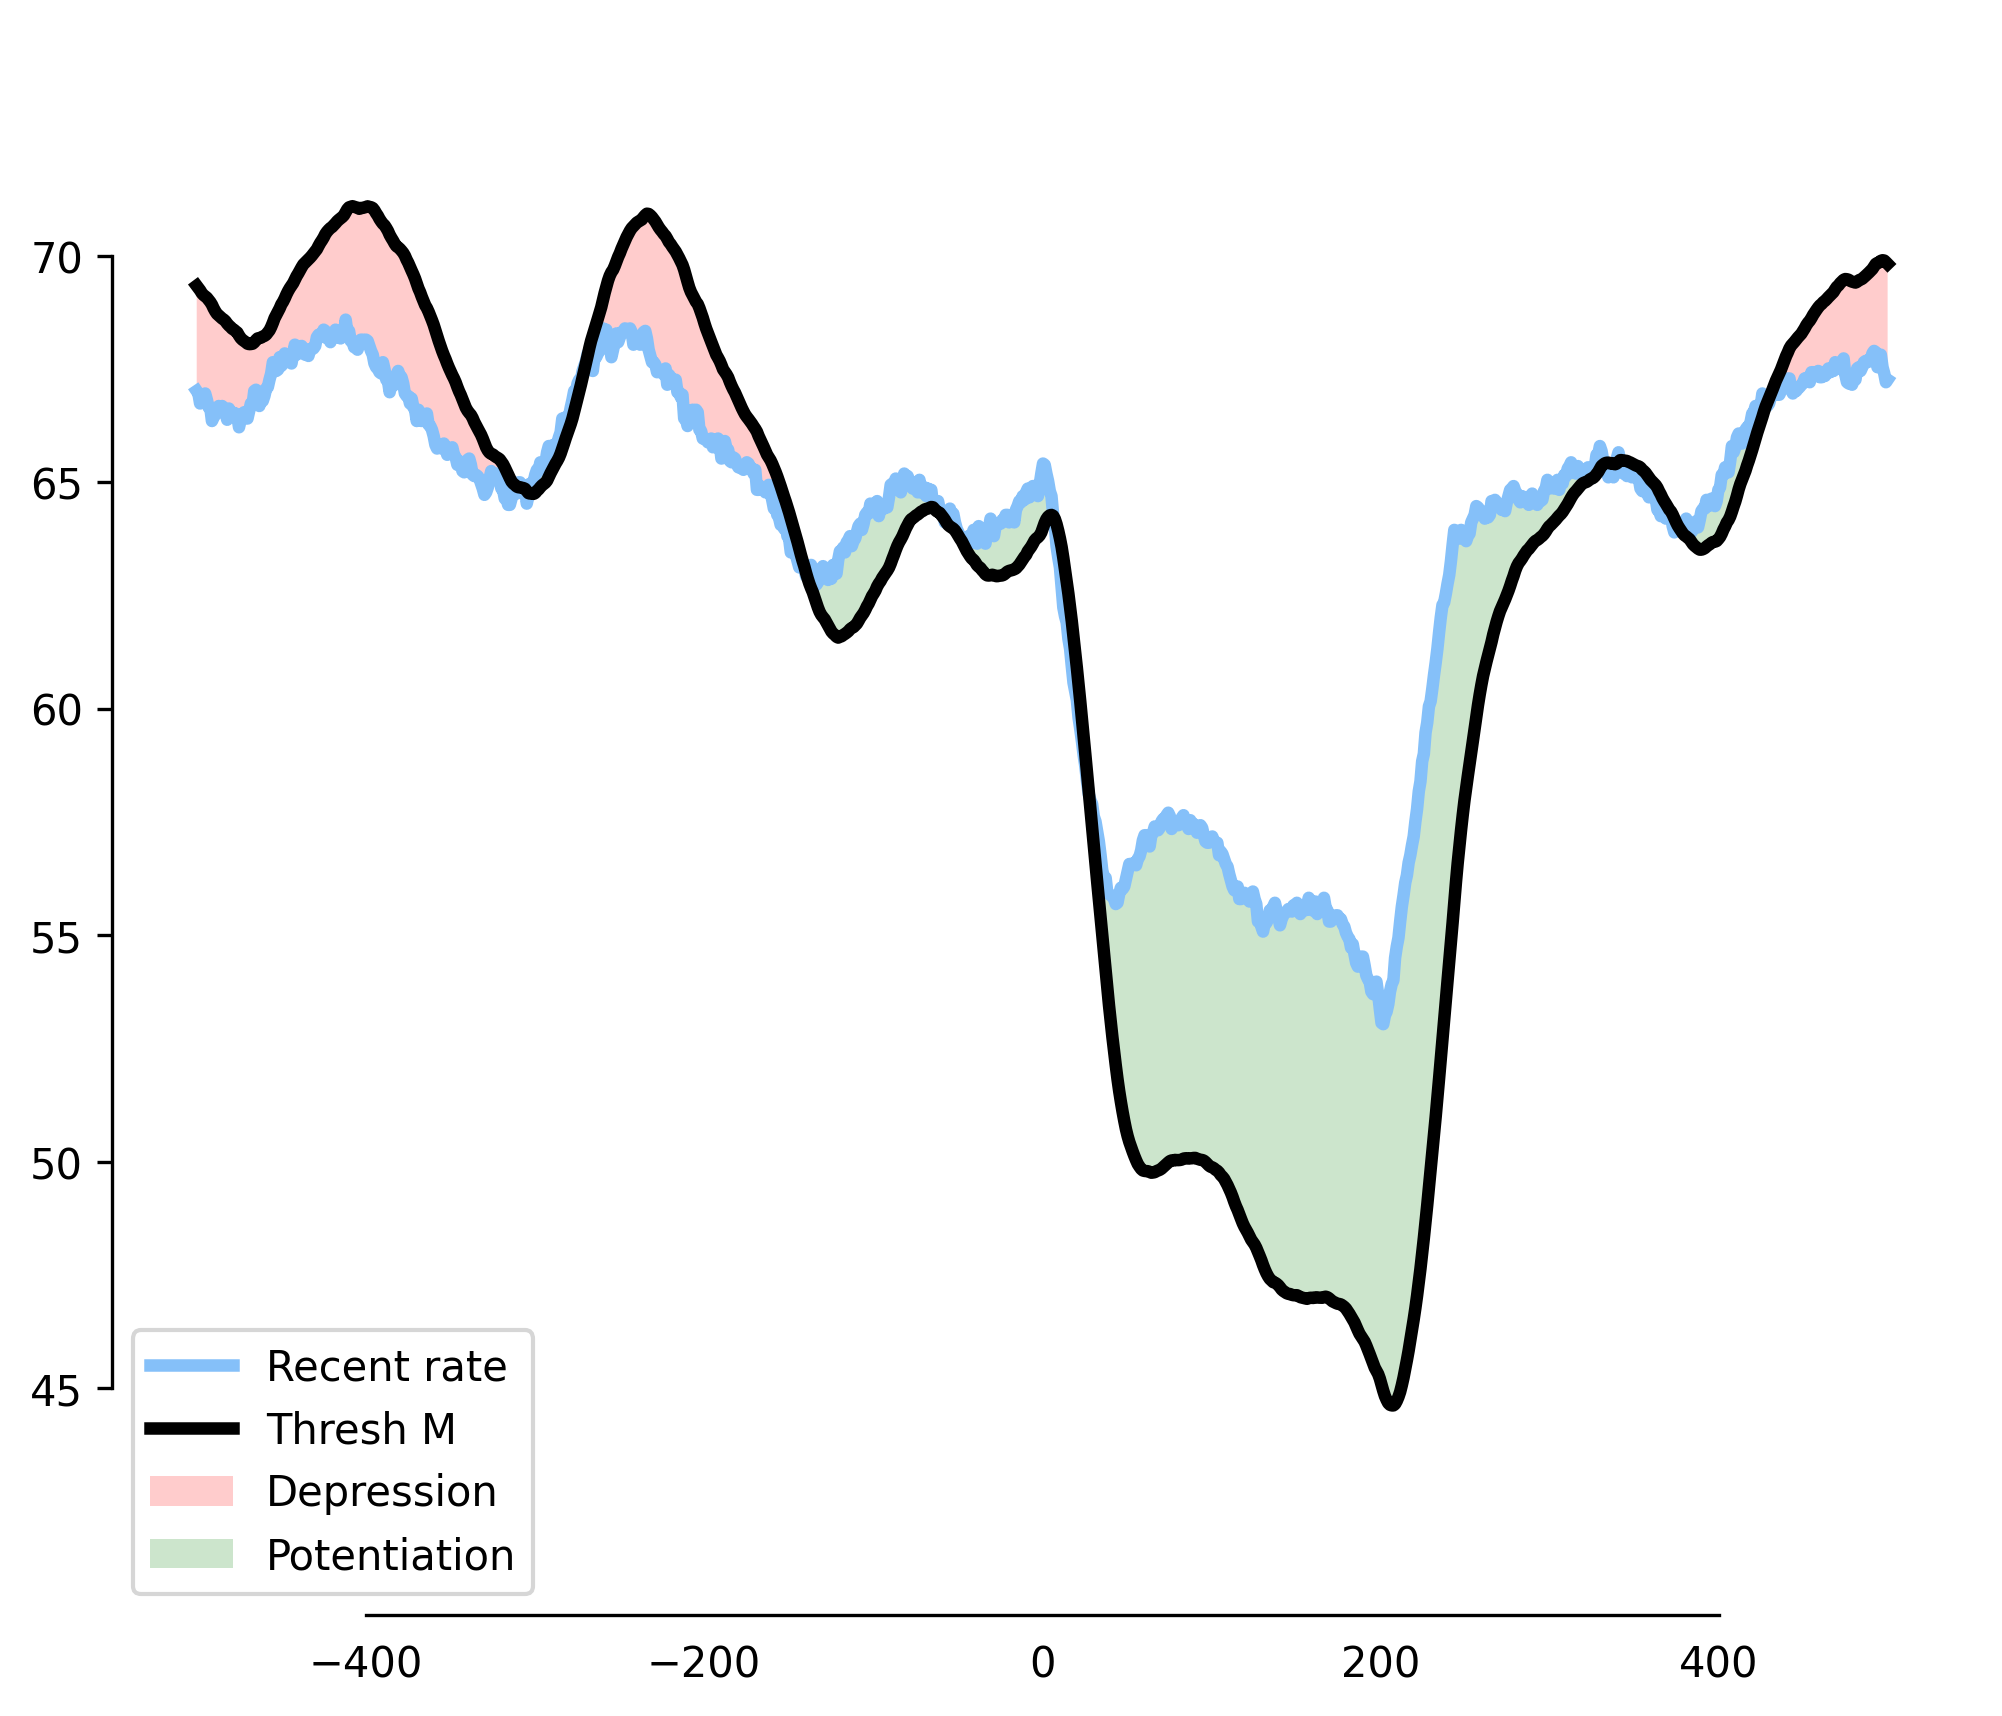

CPU times: user 5.46 s, sys: 9.24 s, total: 14.7 s
Wall time: 1min 44s


In [98]:
%%time
step = 0.5
for zebrin in zebrin_range:
    for plasticity in range_plasticity[0:1]:
        coupling = coupling_range[1]
        seed_number = seed_number_range[0]
        IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources
        fig = plt.figure(figsize=(8,7),dpi=300)
#         plt.title(f'CS triggered BCM {plasticity} Zebrin {zebrin}')
        PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
        IO_spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
        mon_PC_output = output_load_run('mon_N_PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
        PC_trig_big = []
        recent_rate_trig_big = []
        thresh_m_trig_big = []
        IO_trig_big = []
        for pc_num in range(N_Cells_PC):
            spike_times = IO_spikes[f'{IO_num_con[pc_num]}']
            PC_trig = []
            recent_rate_trig = []
            thresh_m_trig = []
            IO_trig = []
            for spike_time in spike_times:
                start = int(spike_time*second/dt_rec)-int(step*second/dt_rec)
                end = int(spike_time*second/dt_rec)+int(step*second/dt_rec)
                if spike_time < step: continue
                if spike_time+step > exp_run/second: continue
                PC_trig.append(PC_output['v'][pc_num][start:end]/mV)
                recent_rate_trig.append(mon_PC_output['rho_PC'][5*pc_num][start:end]/Hz)
                thresh_m_trig.append(mon_PC_output['thresh_M'][5*pc_num][start:end]/Hz)
                IO_trig.append(IO_output['Vs'][IO_num_con[pc_num]][start:end]/mV)
            PC_trig_avg = mean(PC_trig,axis=0)
            recent_rate_trig_avg = mean(recent_rate_trig,axis=0)
            thresh_m_trig_avg = mean(thresh_m_trig,axis=0)
            IO_trig_avg = mean(IO_trig,axis=0)
        PC_trig_big.append(PC_trig_avg)
        recent_rate_trig_big.append(recent_rate_trig_avg)
        thresh_m_trig_big.append(thresh_m_trig_avg)
        IO_trig_big.append(IO_trig_avg)
        plot(linspace(-step*1000,step*1000,len(recent_rate_trig_avg)),mean(recent_rate_trig_big,axis=0),'#85C0F9',lw='3',label='Recent rate')
        plot(linspace(-step*1000,step*1000,len(thresh_m_trig_avg)),mean(thresh_m_trig_big,axis=0),'k',lw='3',label='Thresh M')
        fill_between(linspace(-step*1000,step*1000,len(thresh_m_trig_avg)), mean(thresh_m_trig_big,axis=0), mean(recent_rate_trig_big,axis=0), where=mean(thresh_m_trig_big,axis=0)>mean(recent_rate_trig_big,axis=0), alpha=0.2, facecolor='red',linewidth=4, linestyle='dashdot', label="Depression", interpolate=True)
        fill_between(linspace(-step*1000,step*1000,len(thresh_m_trig_avg)), mean(thresh_m_trig_big,axis=0), mean(recent_rate_trig_big,axis=0), where=mean(thresh_m_trig_big,axis=0)<=mean(recent_rate_trig_big,axis=0), alpha=0.2, facecolor='green',linewidth=4, linestyle='dashdot', label="Potentiation", antialiased=True)
        tick_params(bottom=False)
        sns.despine(trim=True)
        plt.legend()
#         axis('off')
        ylim(40,75)
        plt.savefig(f'Fig_2_CS_BCM_{zebrin}.svg')
        fig.patch.set_alpha(0)
        plt.show()

# Figure 2 - C, D, E, F

In [27]:
# for start in [10000,15000,20000,25000,30000]:
#     print(start)
start = 30000
end = start+20000

cmap = plt.get_cmap('twilight')
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

PC_num = 13
IO_num = IO_num_con[PC_num]

plasticity = 'Plasticity'
coupling = '_Coupled'

IO_output = output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
mon_N_PC_output = output_load_run('mon_N_PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)

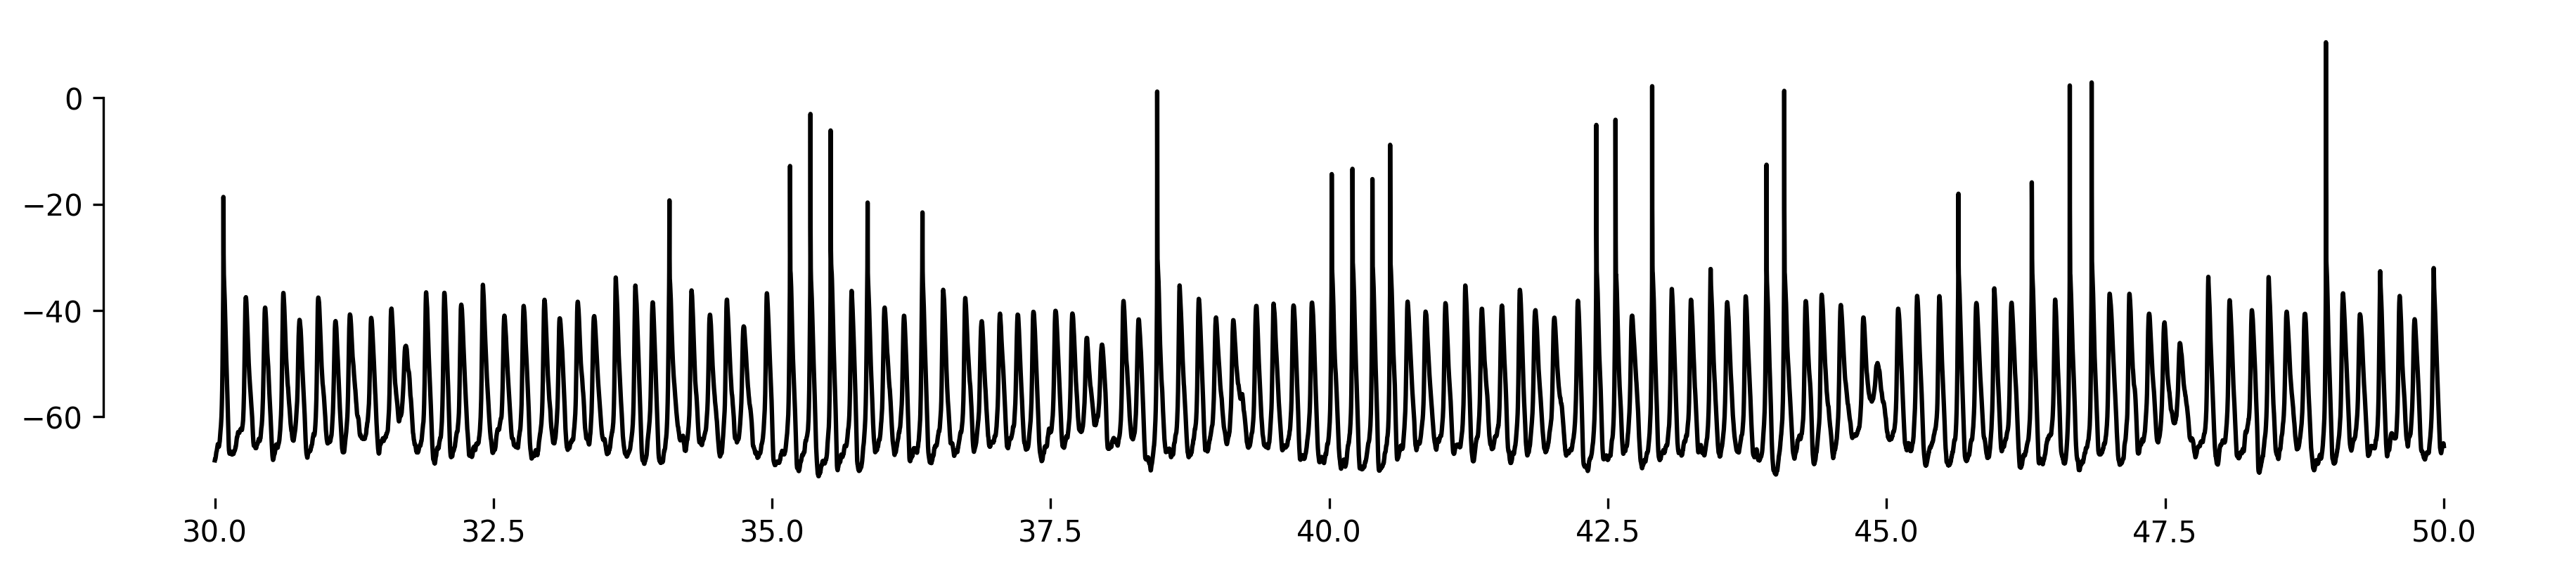

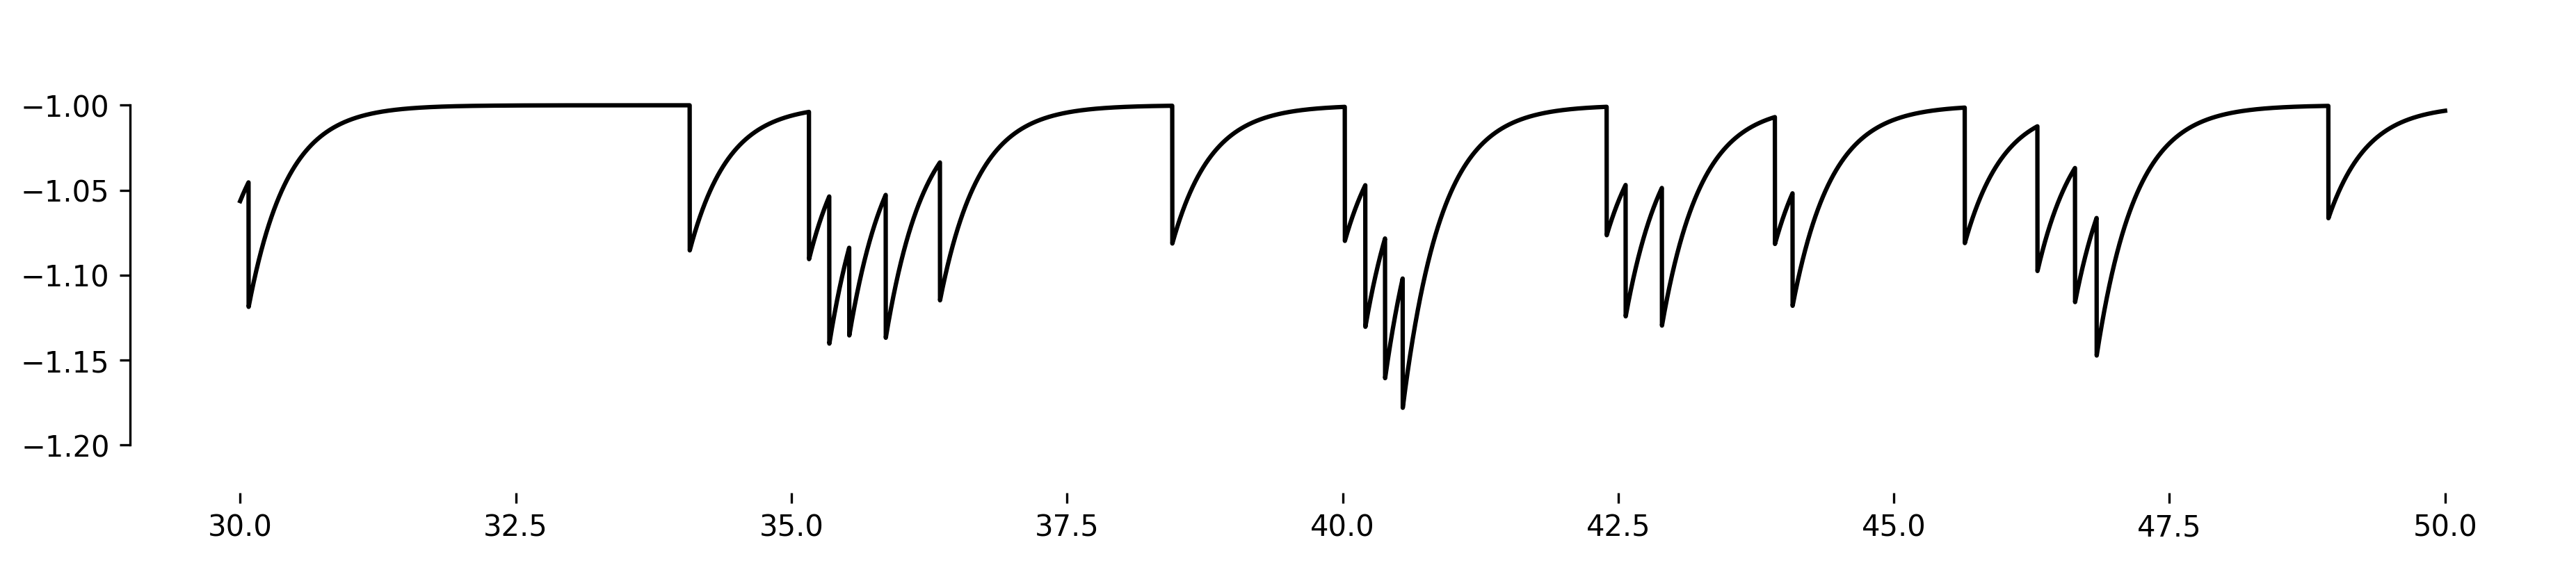

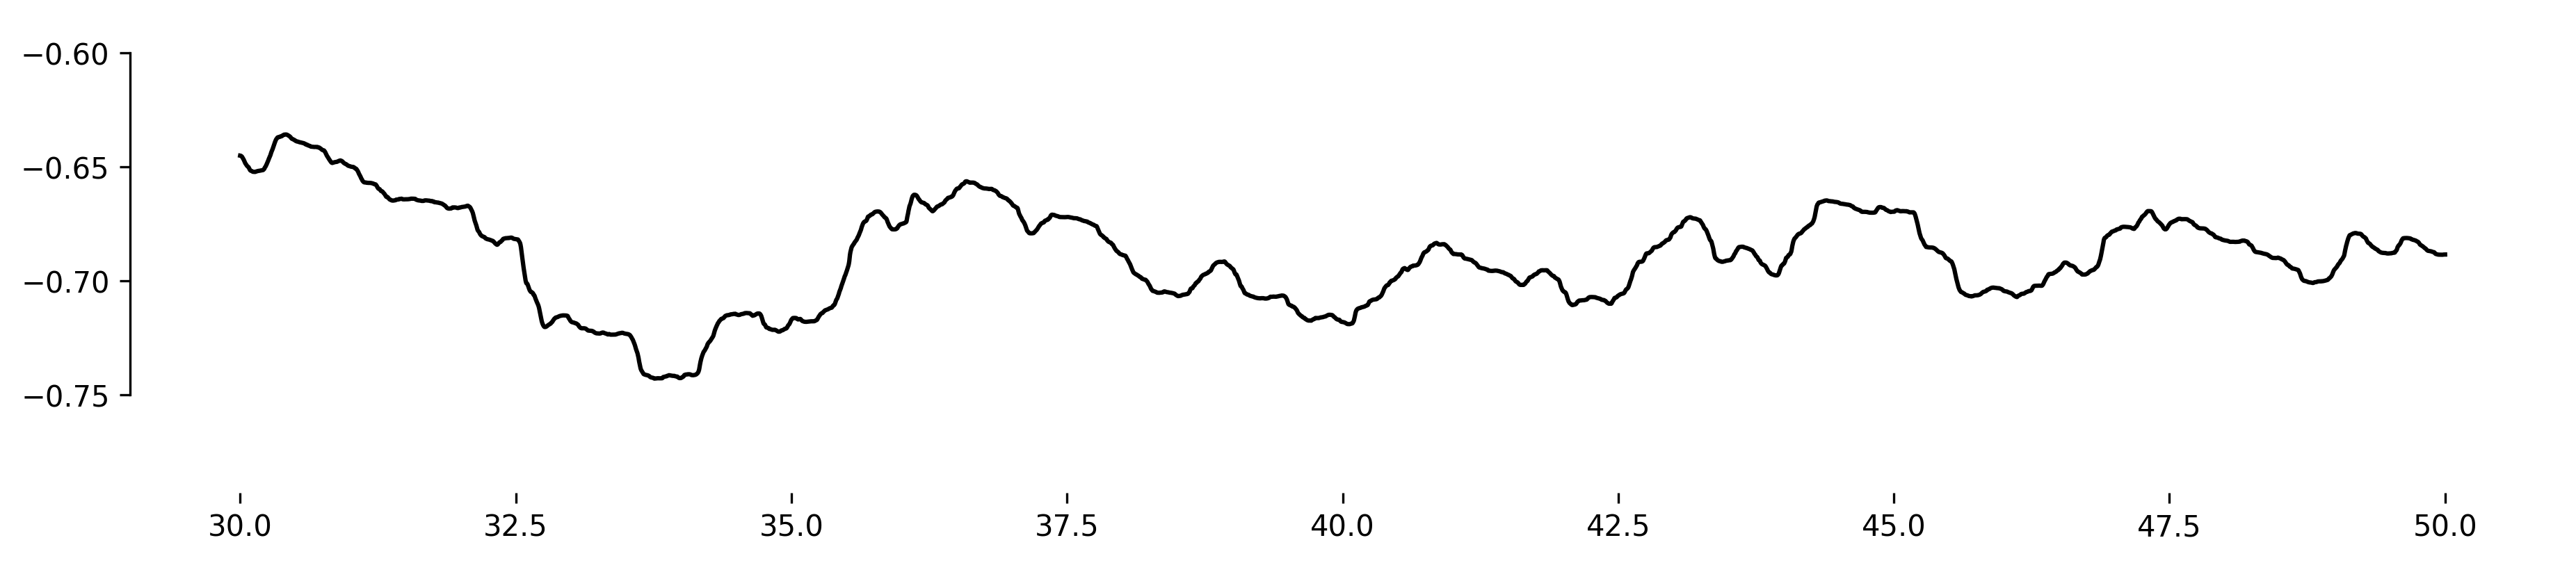

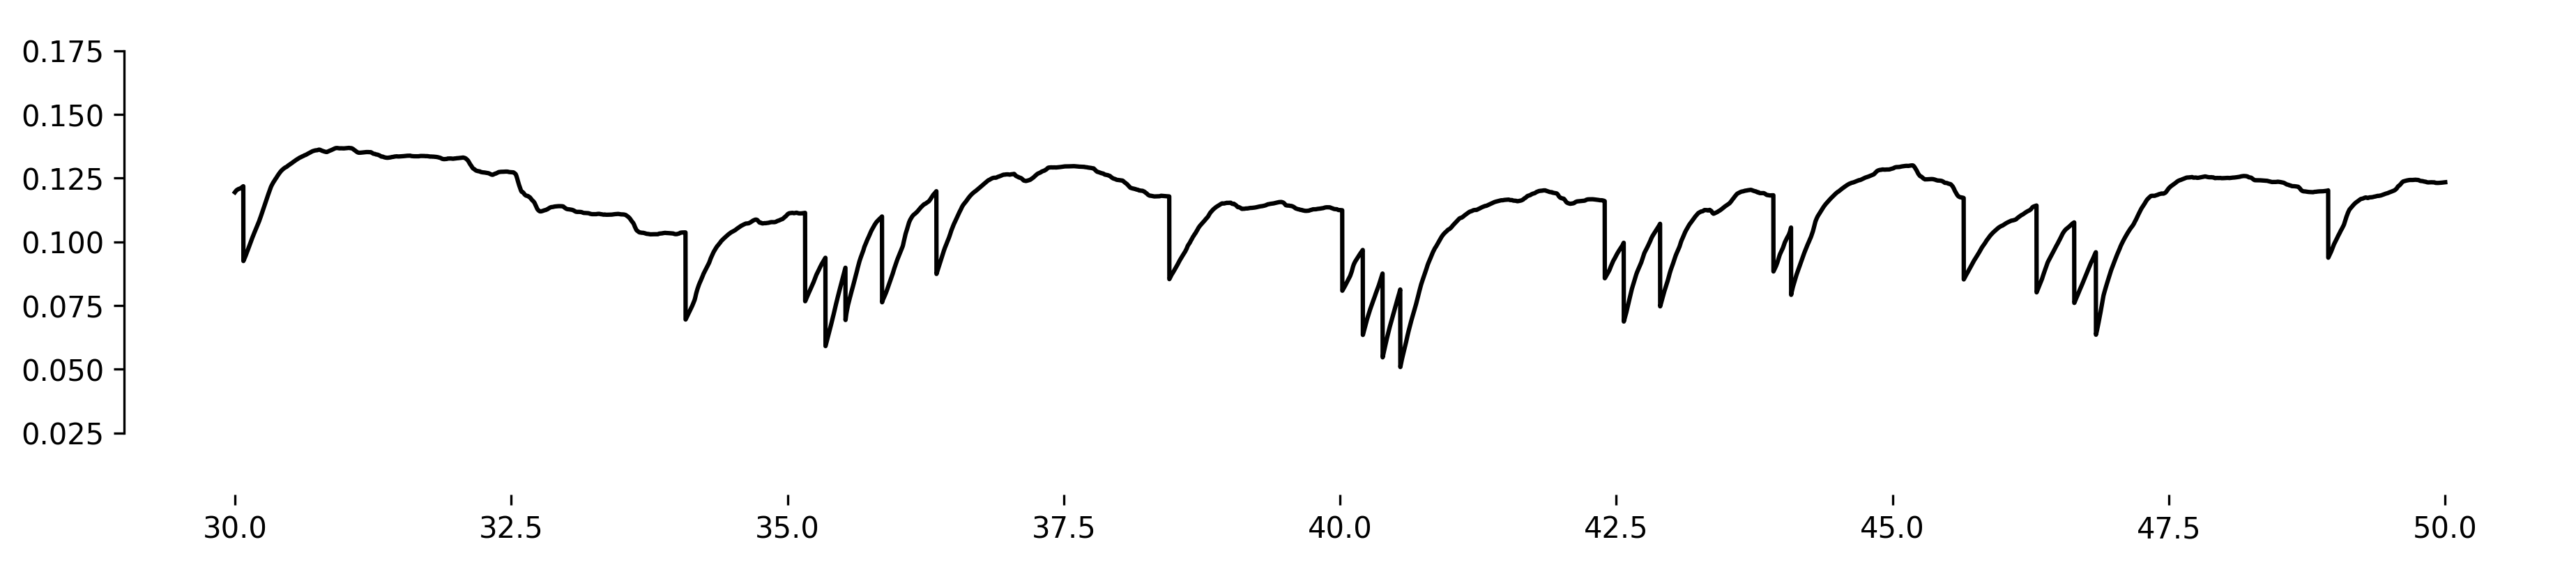

In [28]:
fig = figure(figsize=(15, 3),dpi=300)
plot(linspace(int(start/1000),int(end/1000),int((end-start)/int(dt_rec/ms))),IO_output['Vs'][IO_num][start:end]/mV,c='k')#,color='#85C0F9')
sns.despine(trim=True, bottom = True)
plt.show()

for var in ['delta_weight_CS','delta_weight_BCM','new_weight']:
    fig = figure(figsize=(15, 3),dpi=300)
    x = linspace(int(start/1000),int(end/1000),int((end-start)/int(dt_rec/ms)))
    y = (mon_N_PC_output[var][5*PC_num][start:end]-mon_N_PC_output['new_weight'][5*PC_num][0])/mon_N_PC_output['new_weight'][5*PC_num][0]
    plot(x,y,c='k')#,color='#A95AA1')
    ylim(min(y)-0.05, max(y)+0.05)
    sns.despine(trim=True, bottom = True)
    plt.show()

# Figure 2 - G, H, I, J

In [22]:
%%time

plas_names = ['no_Plasticity']
plas_names.extend(range_after_plasticity)

arr_plas = {}
for f0 in f0_range[0:1]:
    arr_plas[f'{f0}'] = {}
    for zebrin in zebrin_range:
        arr_plas[f'{f0}'][f'{zebrin}'] = {}
        for plasticity in plas_names:
            arr_plas[f'{f0}'][f'{zebrin}'][f'{plasticity}'] = {}
            for coupling in ['_Coupled','']:
                arr_plas[f'{f0}'][f'{zebrin}'][f'{plasticity}'][coupling] = output_load_run('mon_N_PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['new_weight'][:,0]

CPU times: user 6.51 s, sys: 37.5 s, total: 44.1 s
Wall time: 9min 56s


CPU times: user 1.71 s, sys: 2.74 s, total: 4.45 s
Wall time: 17.3 s


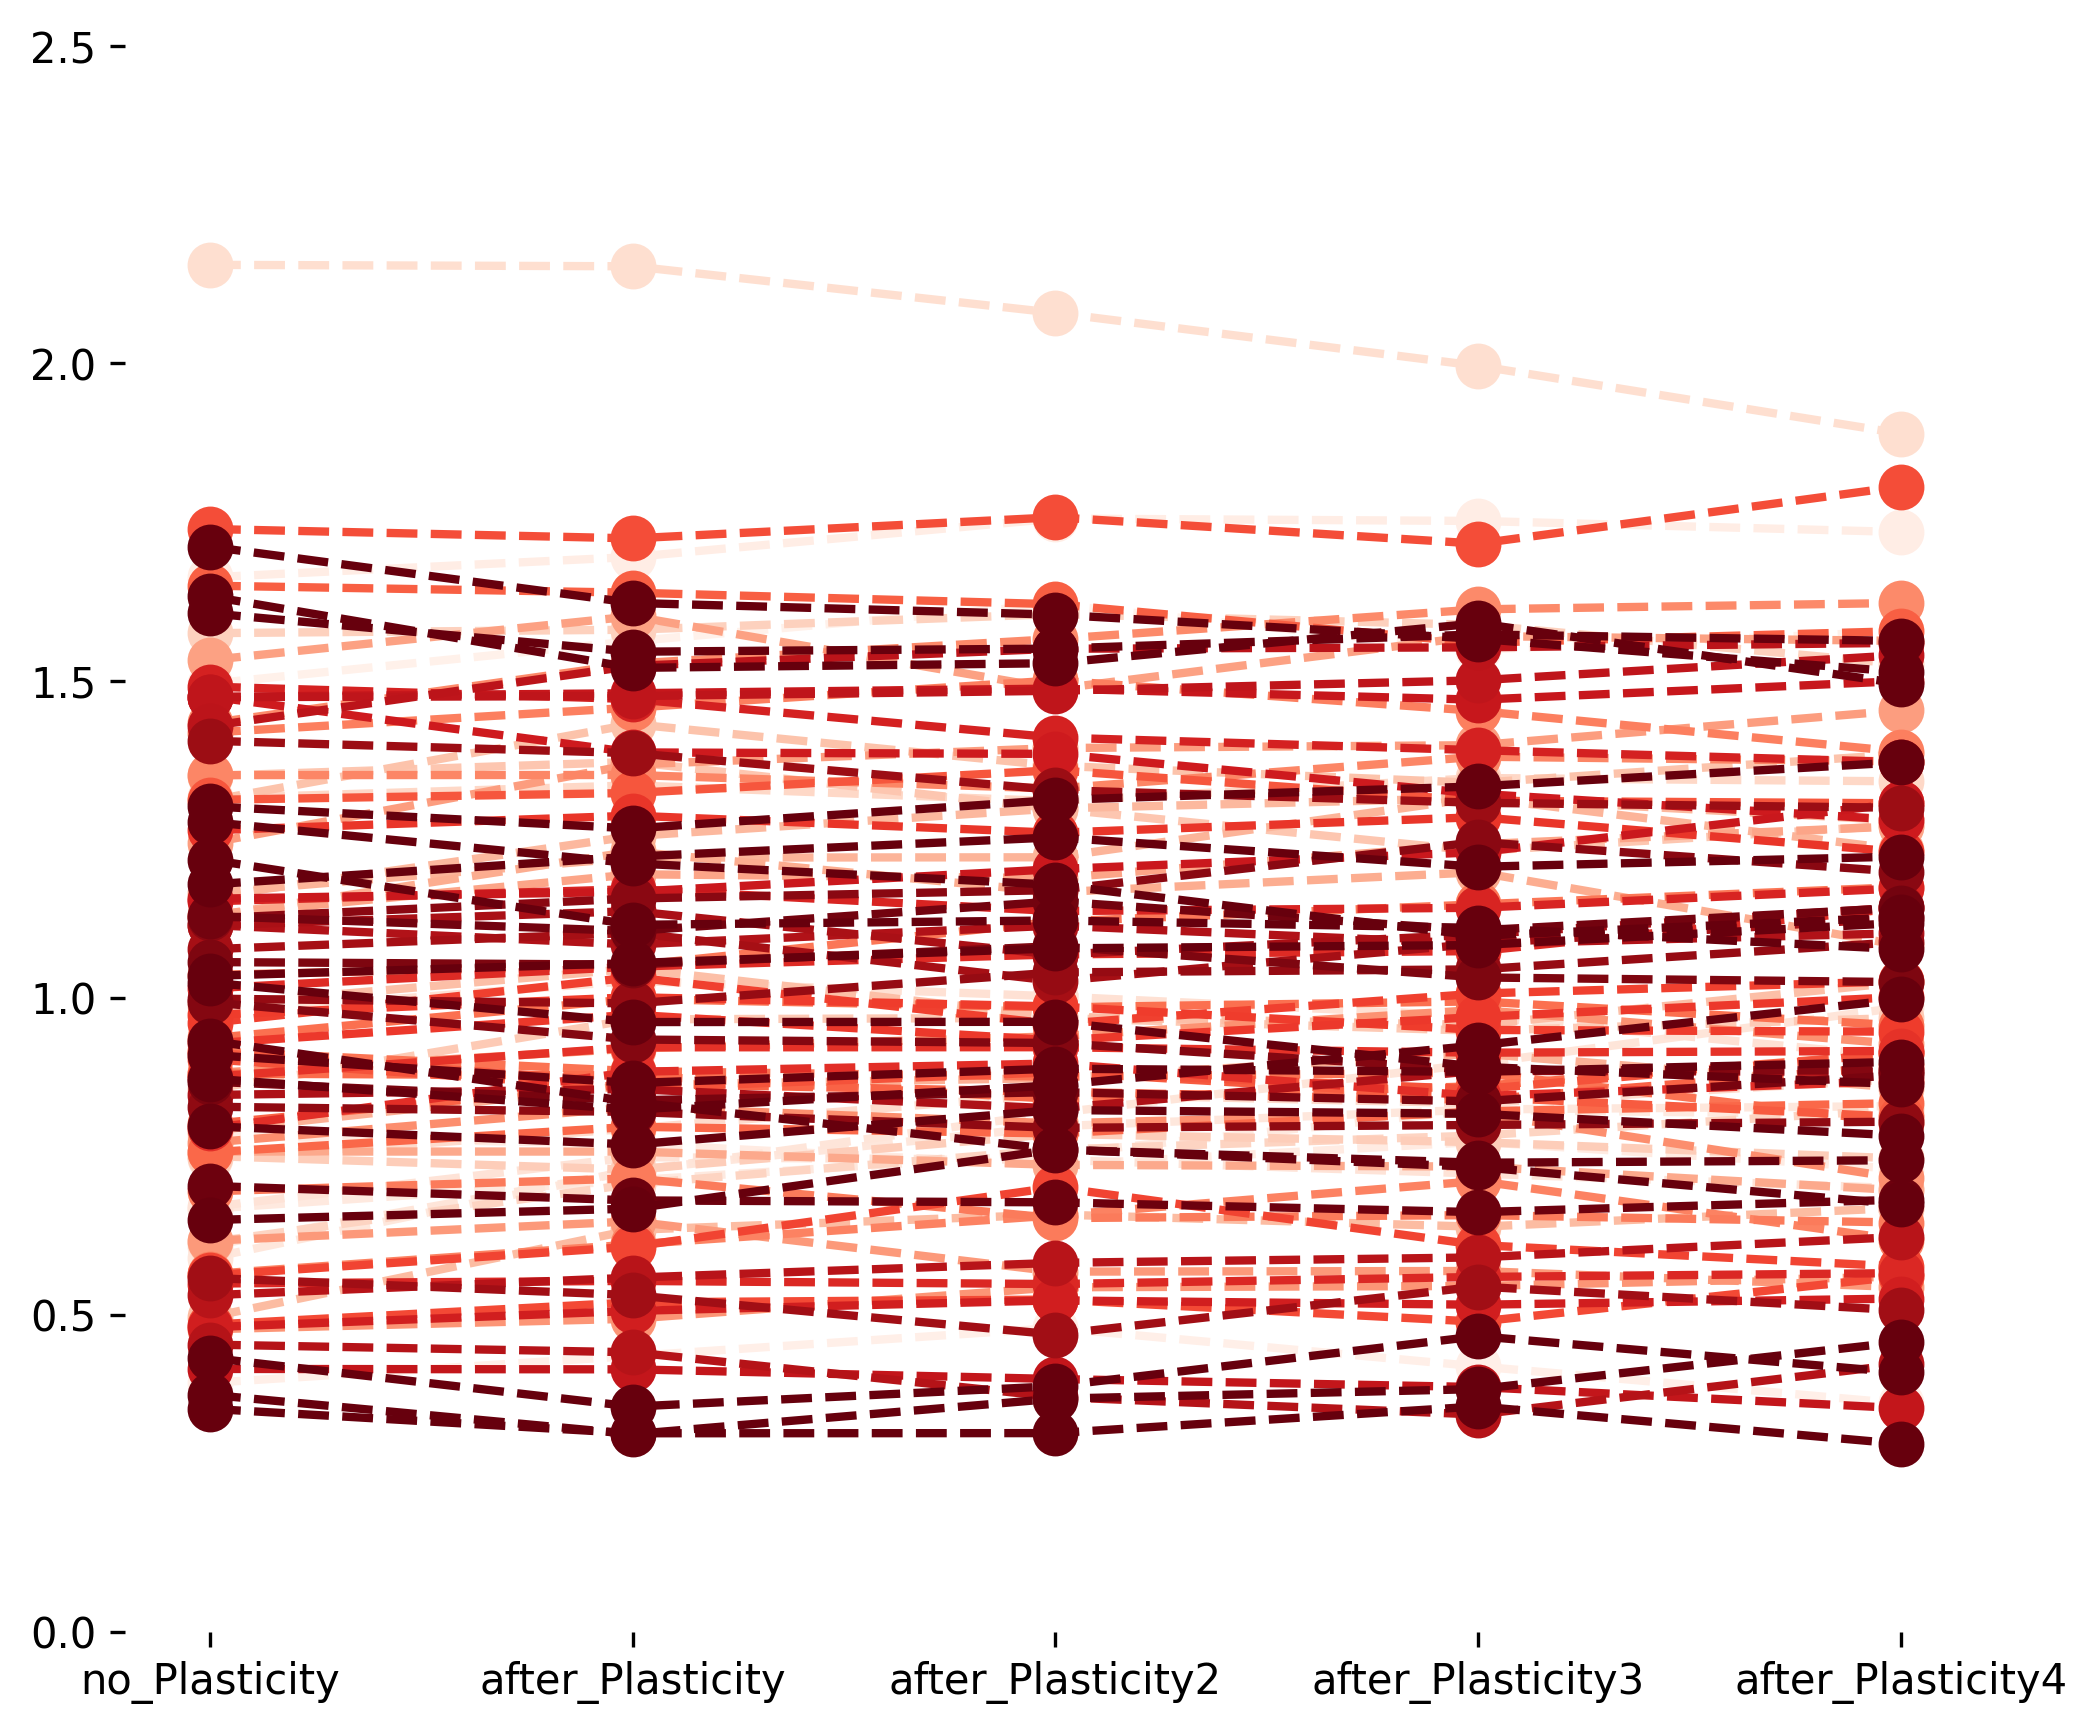

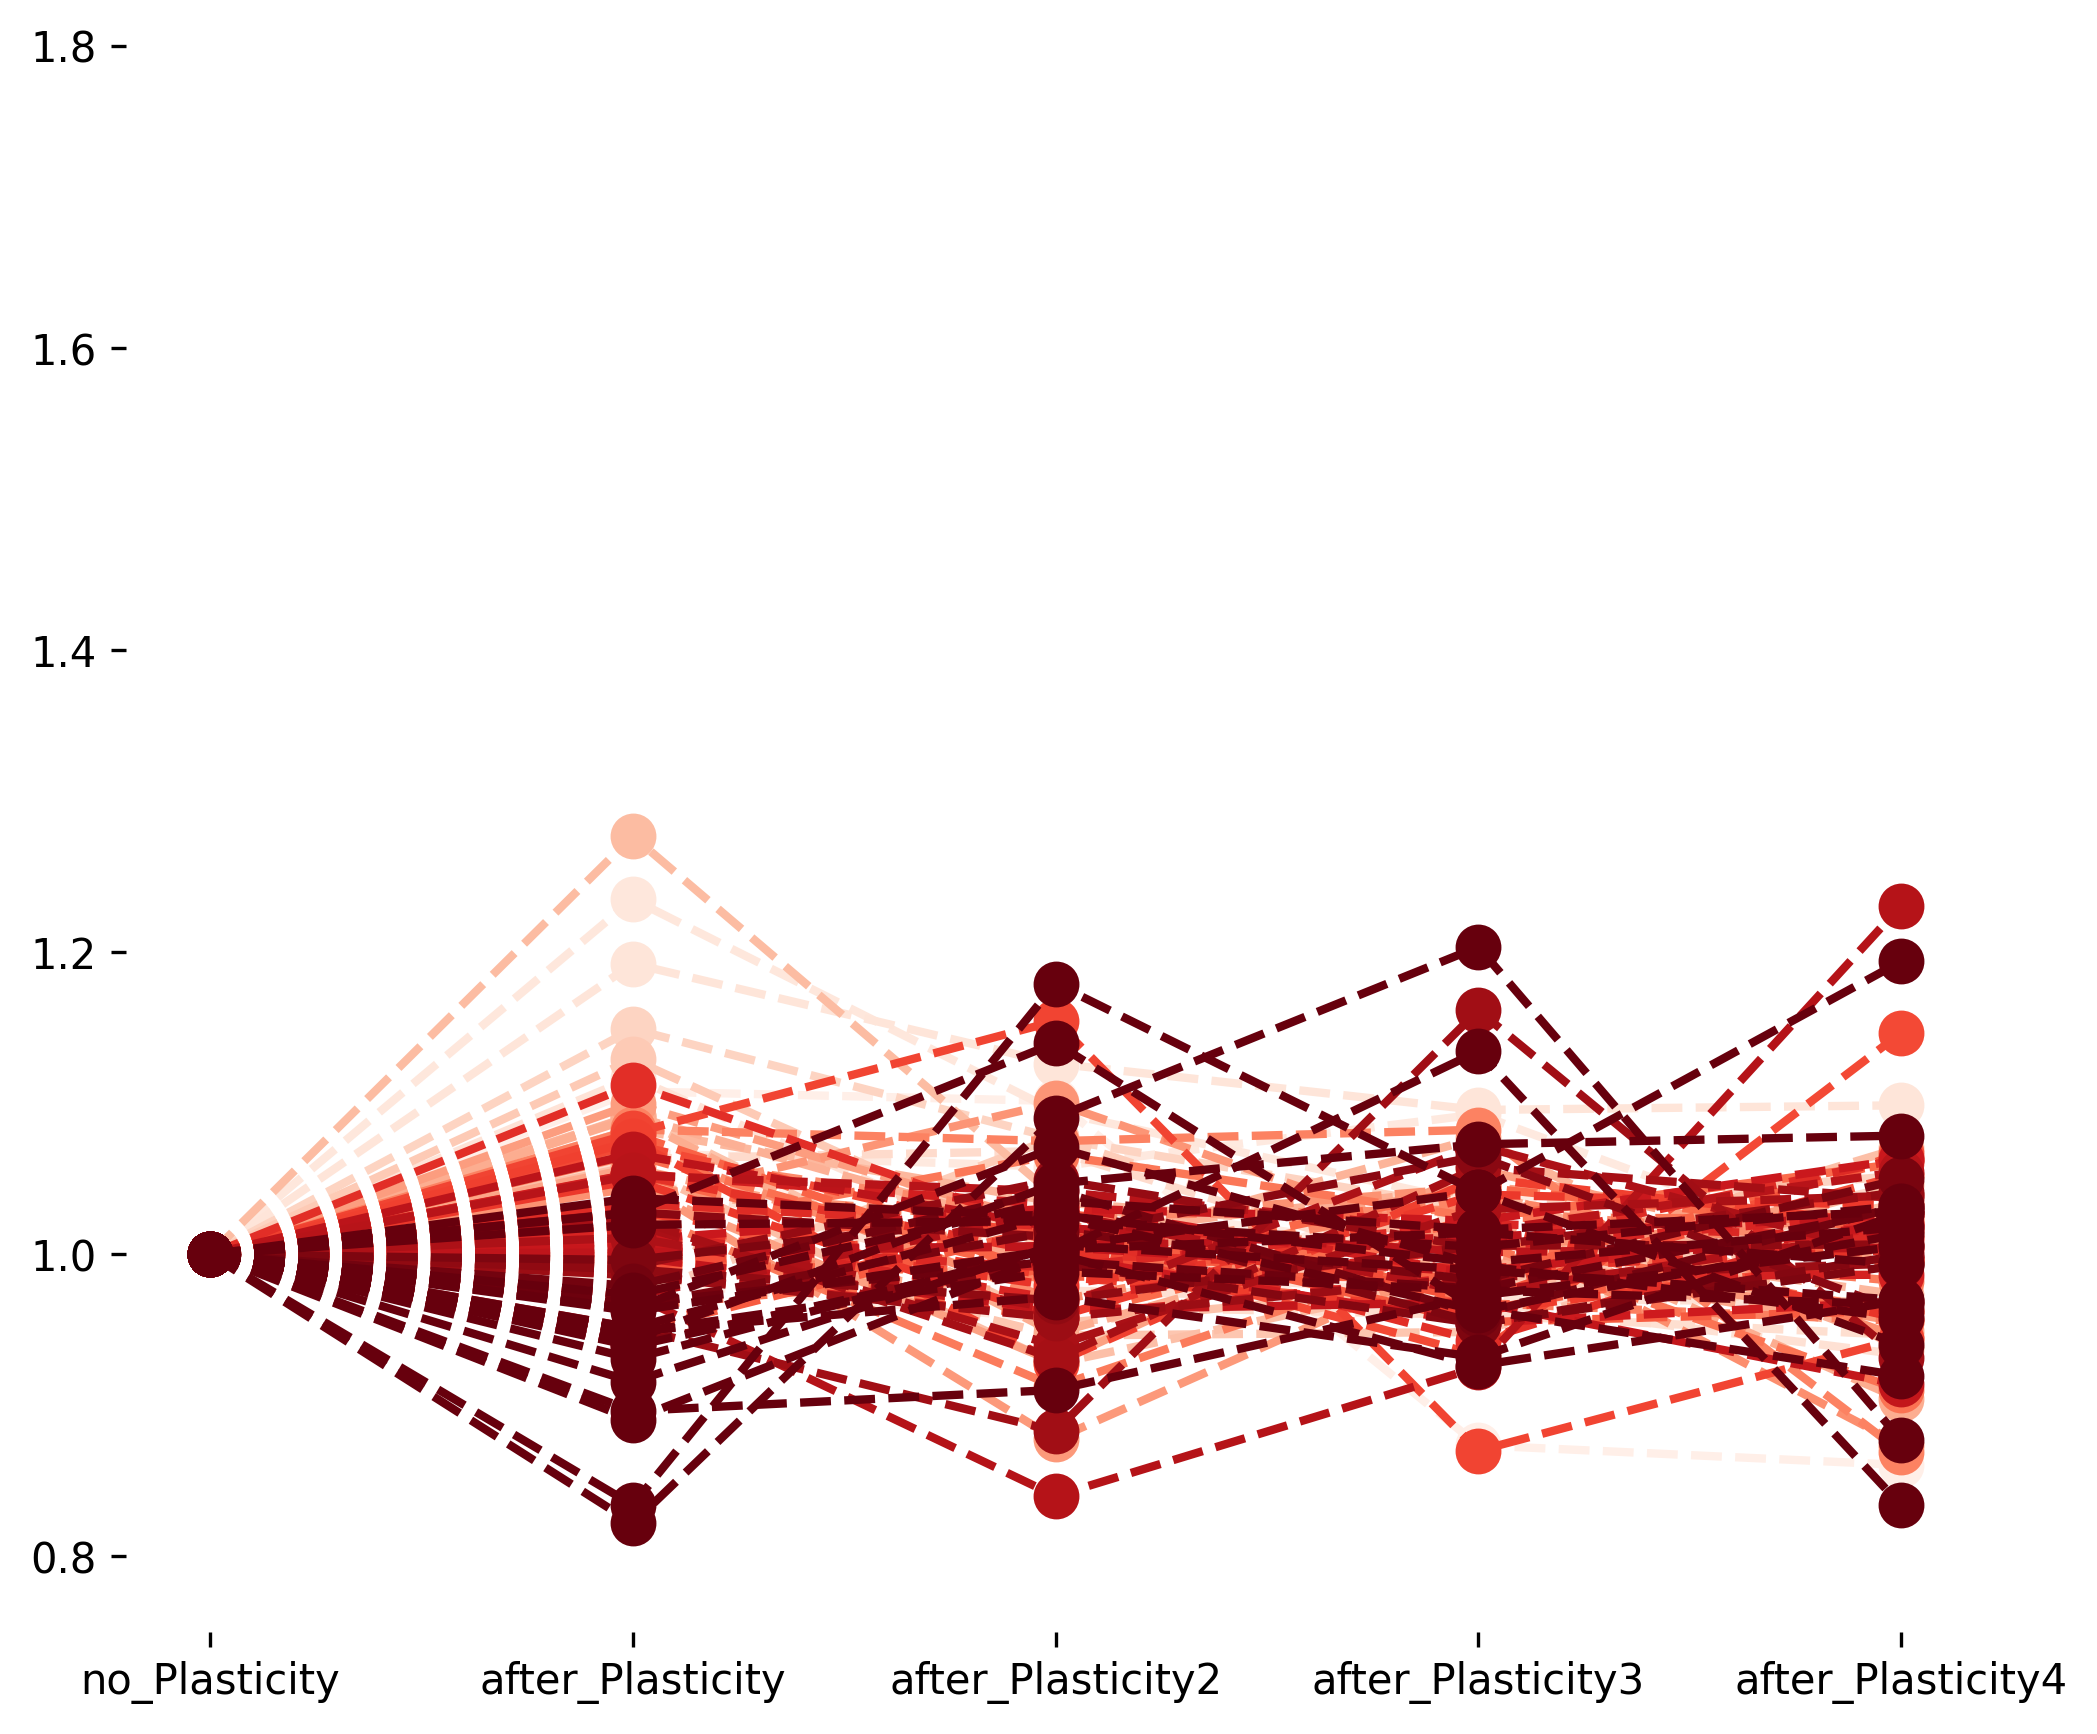

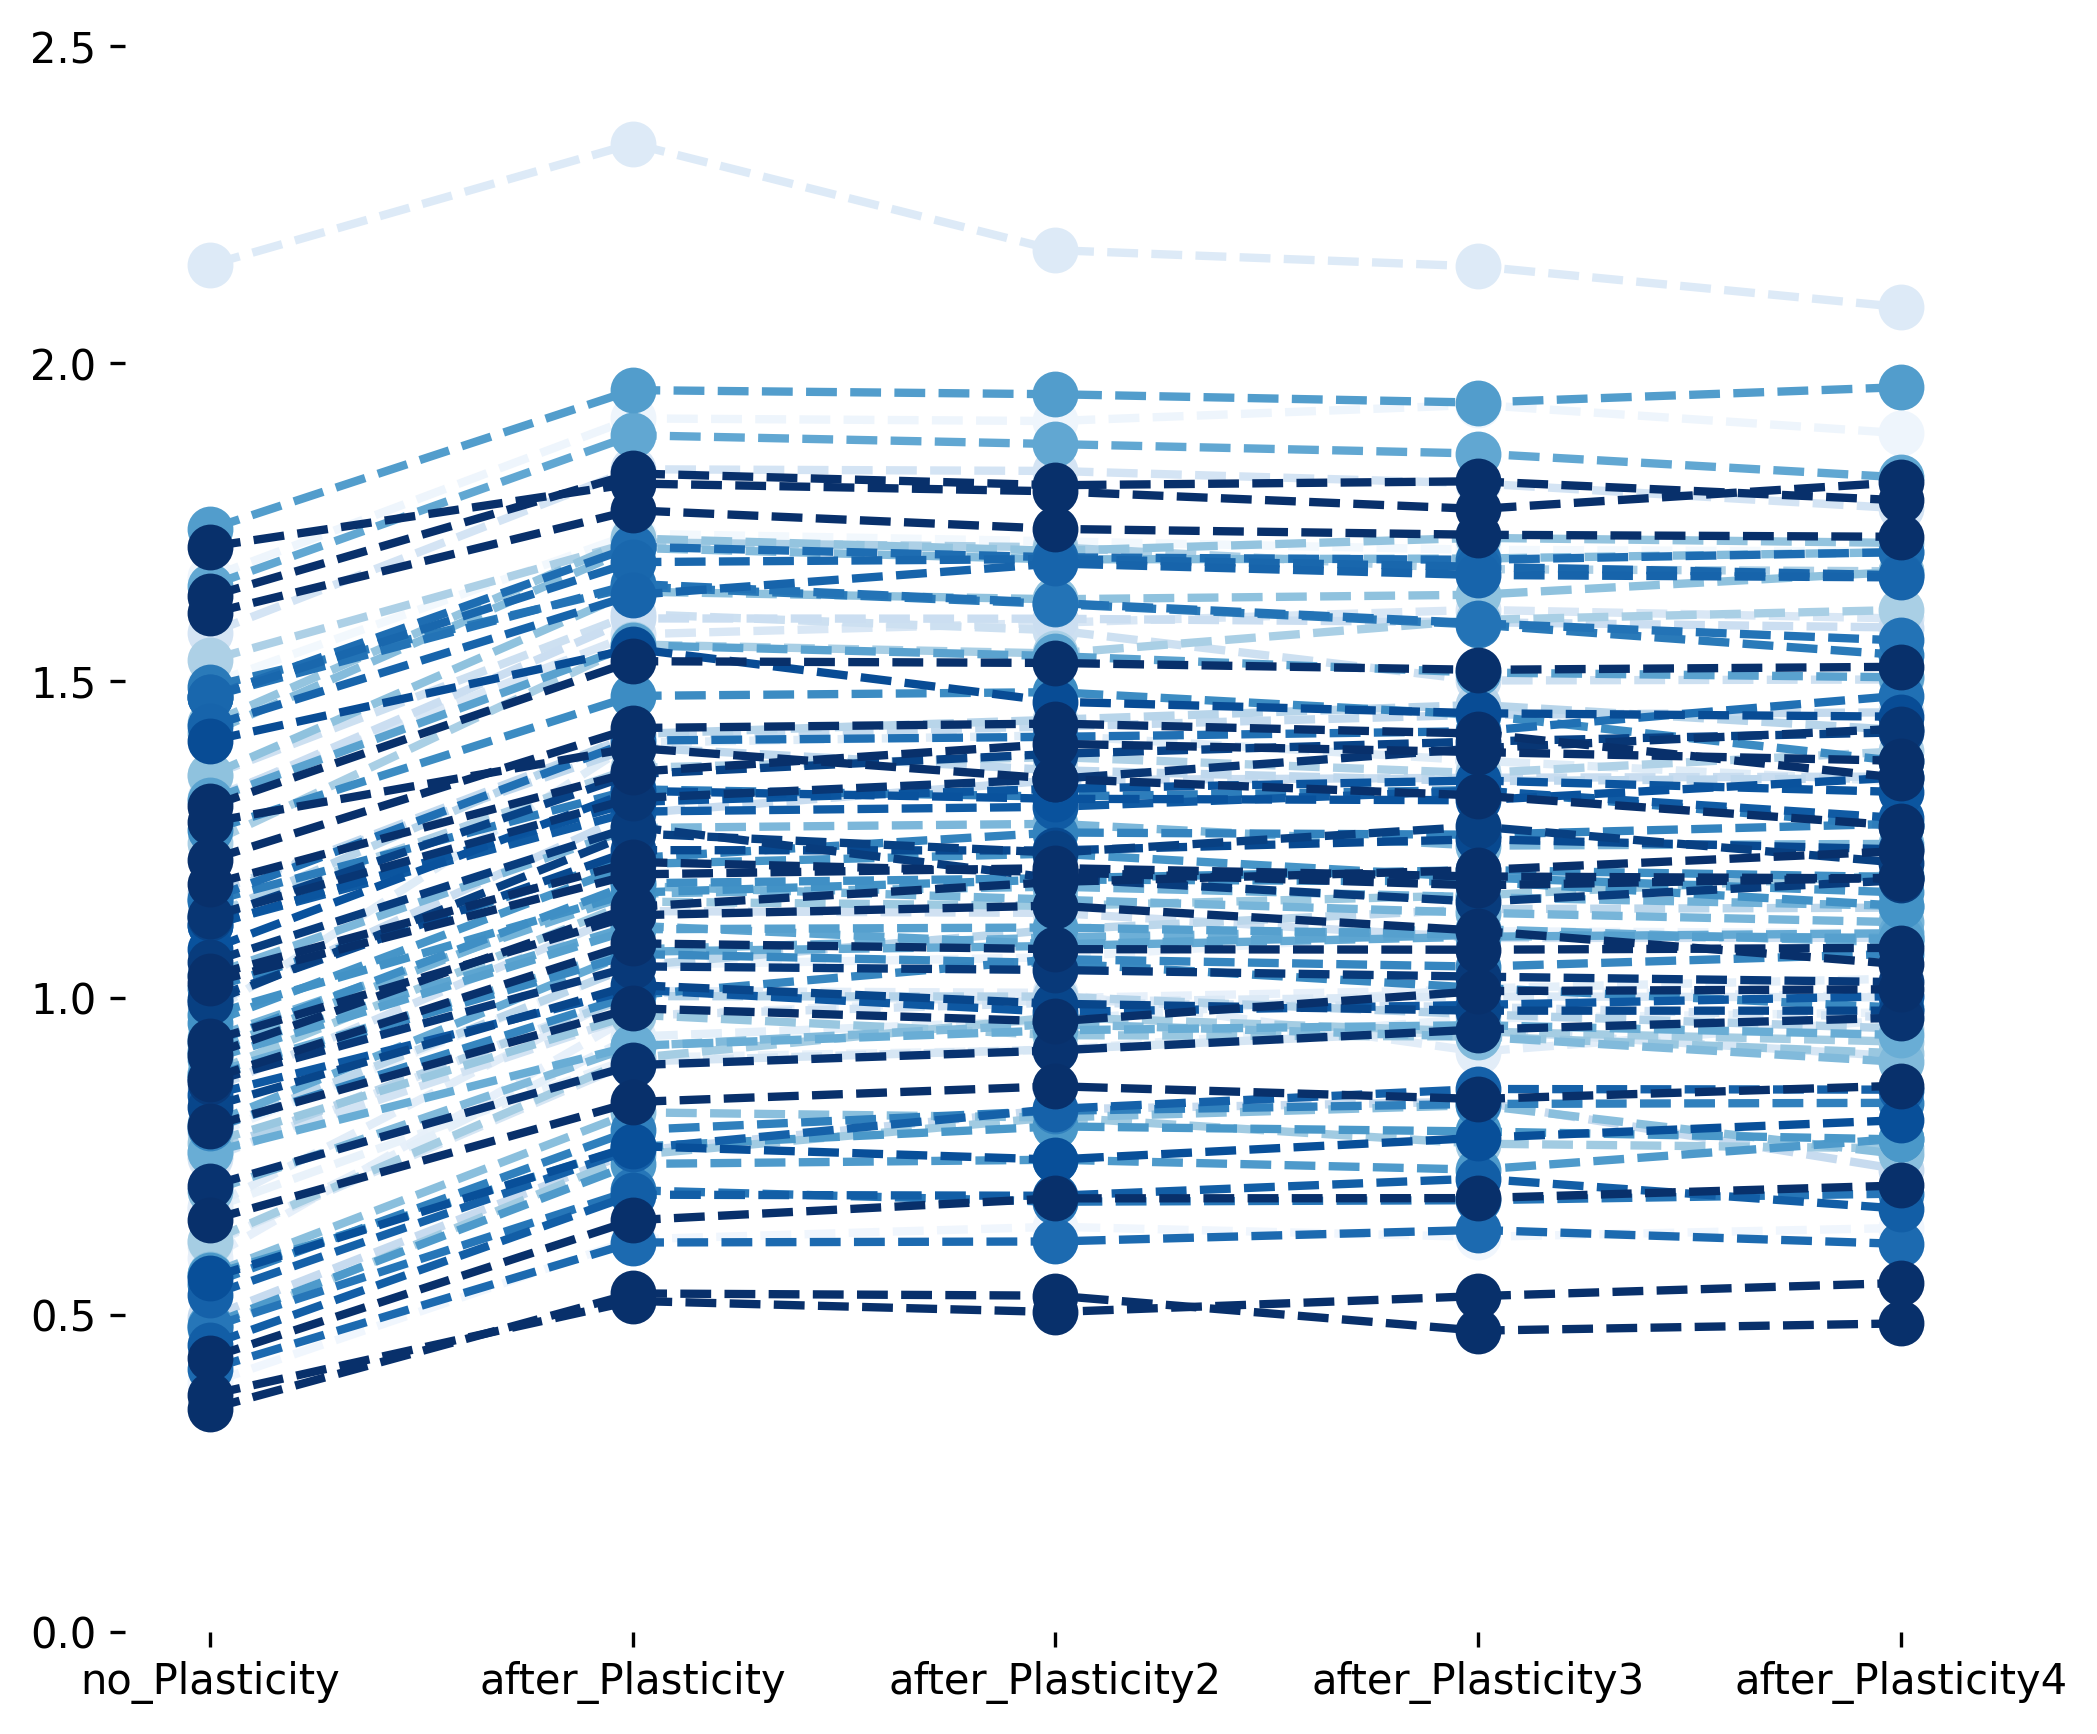

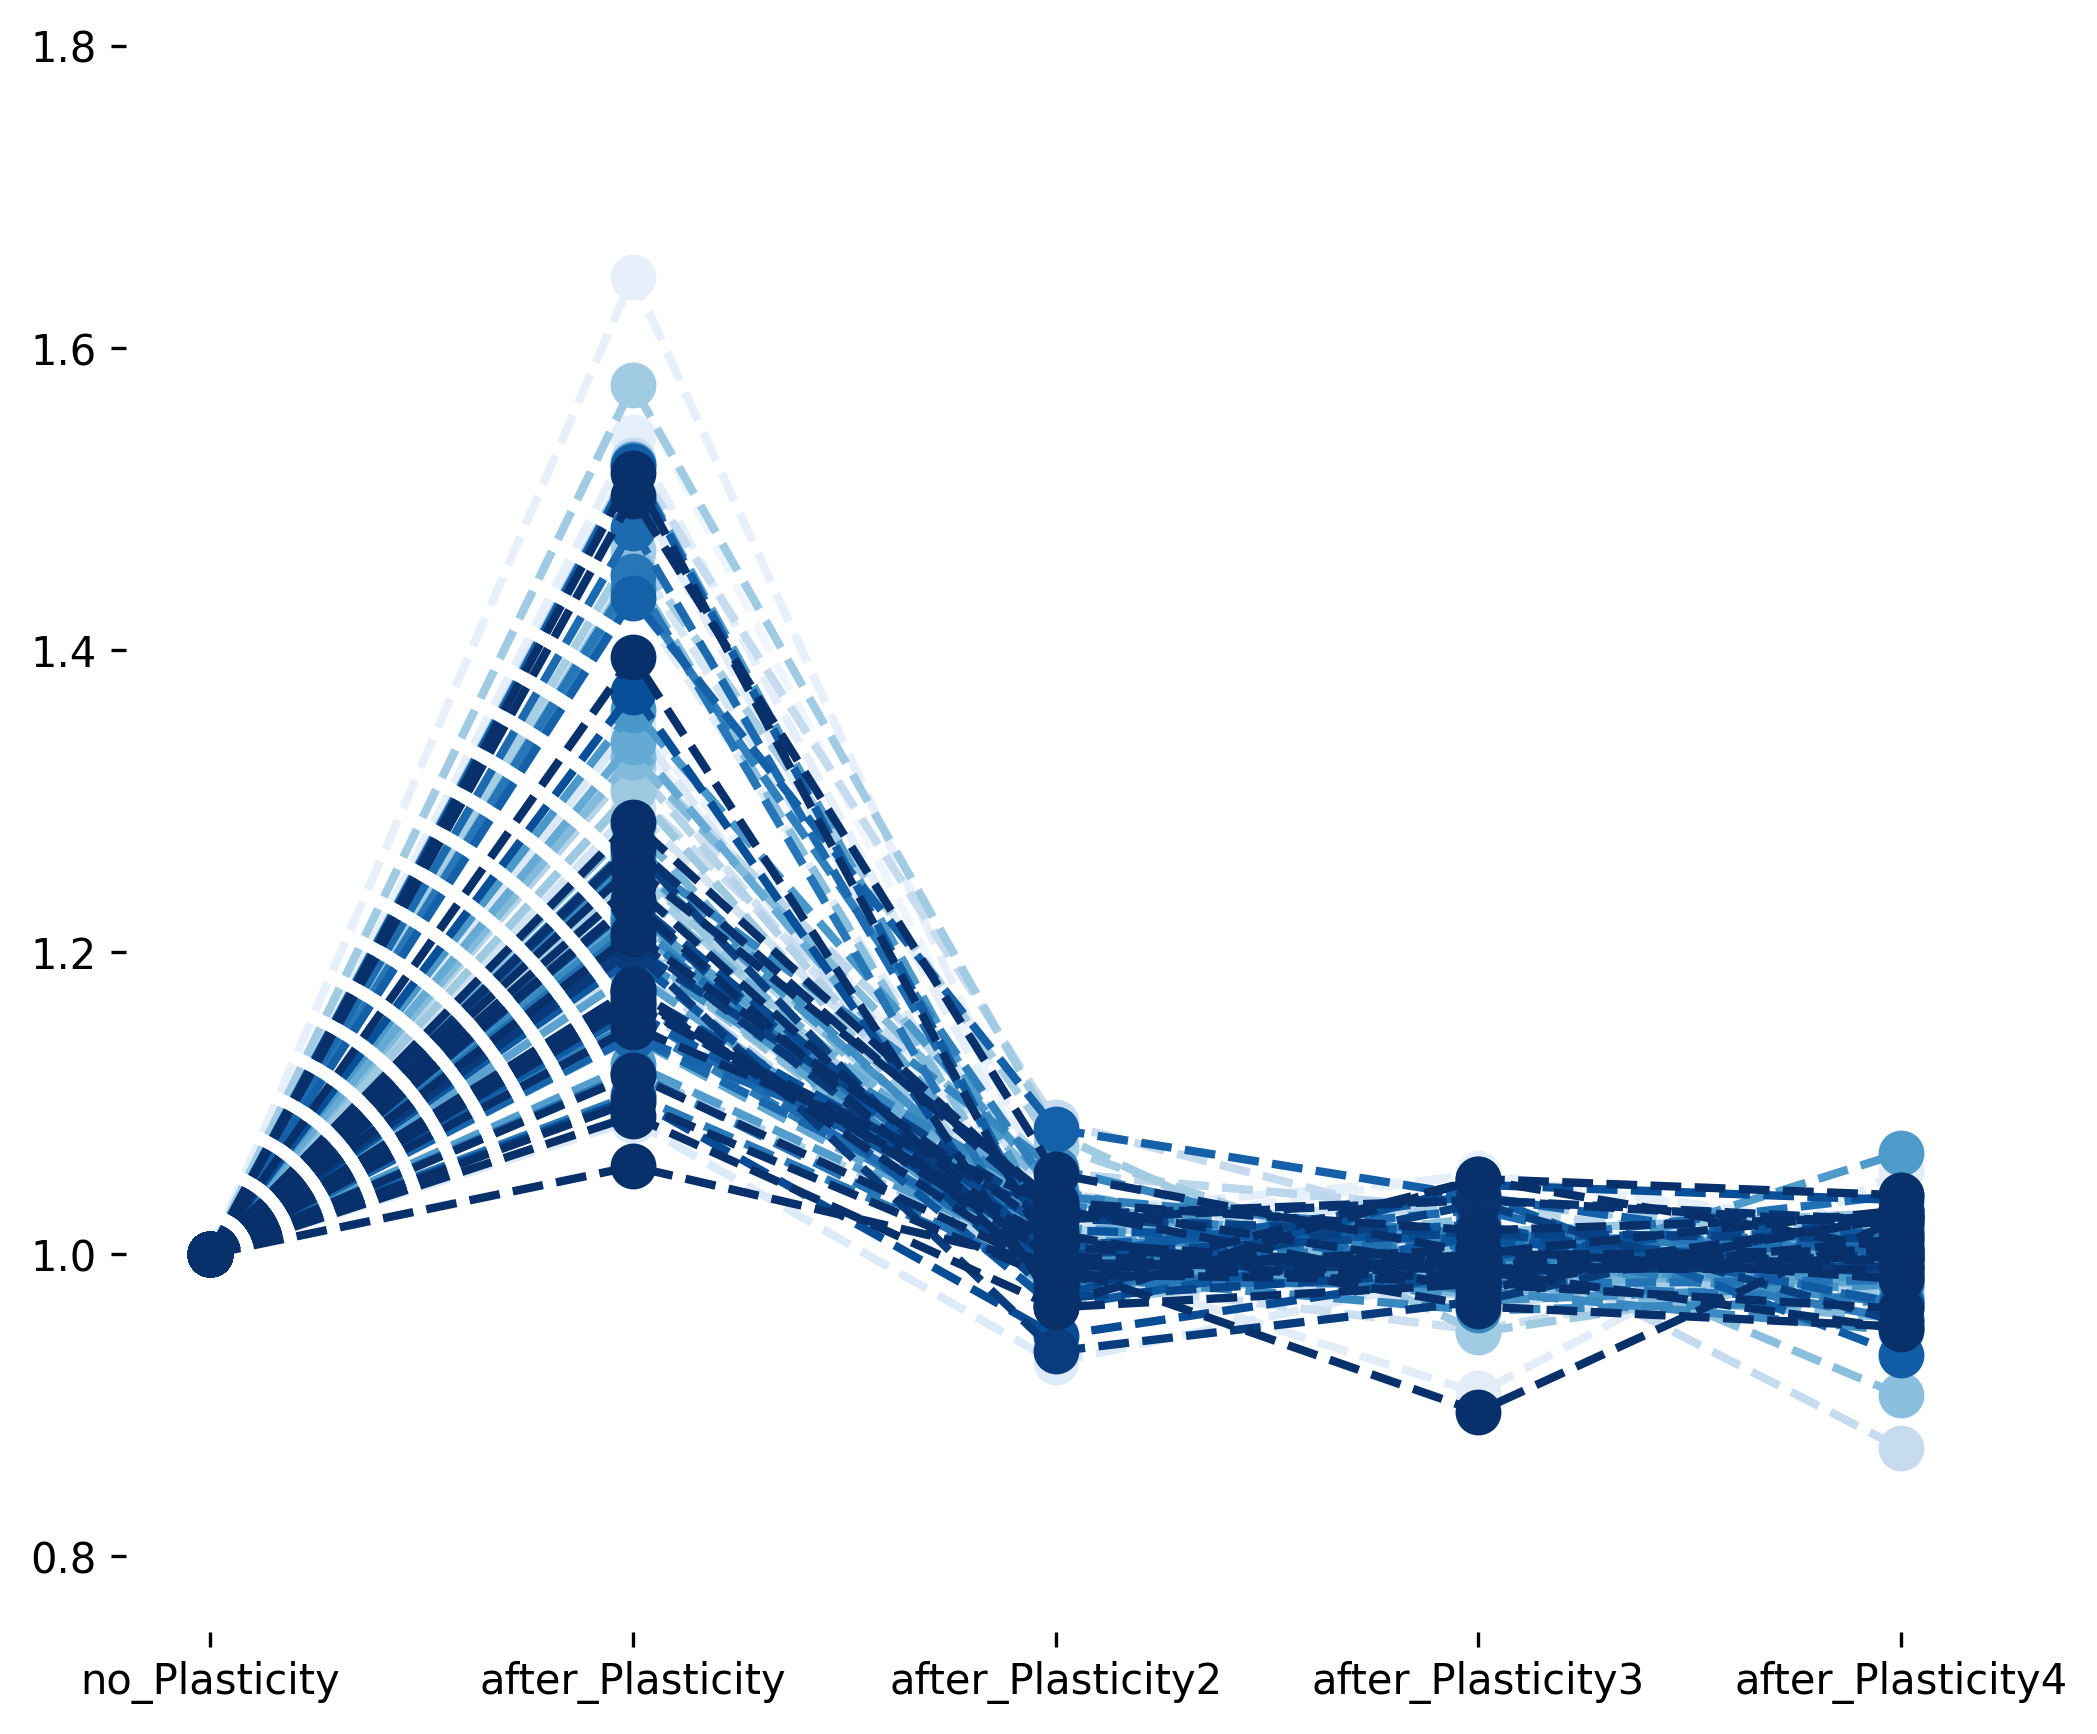

In [102]:
%%time
coupling = '_Coupled'

plas_names = ['no_Plasticity']
plas_names.extend(range_after_plasticity)

f0_name = {}
height = {}
y_loc = {}
f0_name_arr = []
for f0 in f0_range[0:1]:
    step = 5
    if f0 >= 50: 
        step = 25
    if f0 >= 100: 
        step = 50
    lowcut = f0
    highcut = lowcut + step
    if f0 == 800:
        lowcut = 1
        highcut = f0 
    fname = f'F{lowcut}-{highcut} Hz'
    if f0 == 0:
        fname = f'NF'
    elif f0 == 1000:
        fname = '1-200,200-400,\n 400-600,600-800 \n and 1-800'
    elif f0 == 1100:
        fname = 'Sine and original OU'
    elif f0 == 1200:
        fname = 'Sine and different filtered'
    elif f0 == 1300:
        fname = 'Sine added to OU'
    elif f0 == 1400:
        fname = 'Only sine different phases'
    elif f0 == 1500:
        fname = '2,10,50,100,200 Hz sines'
    f0_name_arr.append(fname)
    f0_name[f0] = fname
    height[f0] = highcut-lowcut
    y_loc[f0] = (highcut+lowcut)/2

for zebrin in zebrin_range:
    if zebrin == 'positive':
        cmap = plt.get_cmap('Blues')
    elif zebrin == 'negative':
        cmap = plt.get_cmap('Reds')
        
    for f0 in f0_range[0:1]:
        fig = plt.figure(figsize=(8, 7),dpi=300)
#         title(f0_name[f0])
    #     plt.title(f'Changes in weights Zebrin {zebrin}{coupling}')
        for pc_num in range(N_Cells_PC):
            y = []
            for name in plas_names:
                point = arr_plas[f'{f0}'][f'{zebrin}'][f'{name}'][coupling][pc_num]
                y.append(point)
            x = range(len(plas_names))     
            plt.plot(x, y, color = cmap(3*(2+pc_num)), marker='o', ms=10, ls='--', lw=2)
#         axis('off')
        ylim([0,2.5])
        xticks(range(len(plas_names)),plas_names)
        sns.despine(bottom=True,left=True)

        fig = plt.figure(figsize=(8, 7),dpi=300)
#         title(f0_name[f0])
    #     plt.title(f'Relative to previous Zebrin {zebrin}{coupling}')
        for pc_num in range(N_Cells_PC):
            y = []
            for ii,name in enumerate(plas_names):
                if ii == 0: ii = 1
                point = arr_plas[f'{f0}'][f'{zebrin}'][f'{name}'][coupling][pc_num]/arr_plas[f'{f0}'][f'{zebrin}'][f'{plas_names[ii-1]}'][coupling][pc_num]
                y.append(point)
            x = range(len(plas_names))     
            plt.plot(x, y, color = cmap(3*(2+pc_num)), marker='o', ms=10, ls='--', lw=2)
        ylim([0.75,1.8])
        xticks(range(len(plas_names)),plas_names)
#         axis('off')
        sns.despine(bottom=True,left=True)

# Figure 2 - K, L

In [39]:
%%time
cmap = plt.get_cmap('Blues')
coupling = '_Coupled'

plas_names = ['no_Plasticity']
plas_names.extend(range_after_plasticity)


colors = dict(positive='#1c4981',negative='#8a1218')

data = []
for coupling in (['', '_Coupled']):
    for zebrin in zebrin_range:
        for ii,plasticity in enumerate(range_after_plasticity):
            if ii == 0:
                diff_arr = arr_plas[f'{f0}'][f'{zebrin}'][f'{plasticity}'][coupling]-arr_plas[f'{f0}'][f'{zebrin}'][f'no_Plasticity'][coupling]
            else:
                diff_arr = arr_plas[f'{f0}'][f'{zebrin}'][f'{plasticity}'][coupling]-arr_plas[f'{f0}'][f'{zebrin}'][f'{range_after_plasticity[ii-1]}'][coupling]
            for diff in diff_arr:
                row = dict(diff = diff)
                row['plasticity'] = plasticity
                row['zebrin'] = zebrin
                row['coupling'] = coupling
                data.append(row)
df_diff = pd.DataFrame(data)

CPU times: user 7.52 ms, sys: 3.28 ms, total: 10.8 ms
Wall time: 10.6 ms


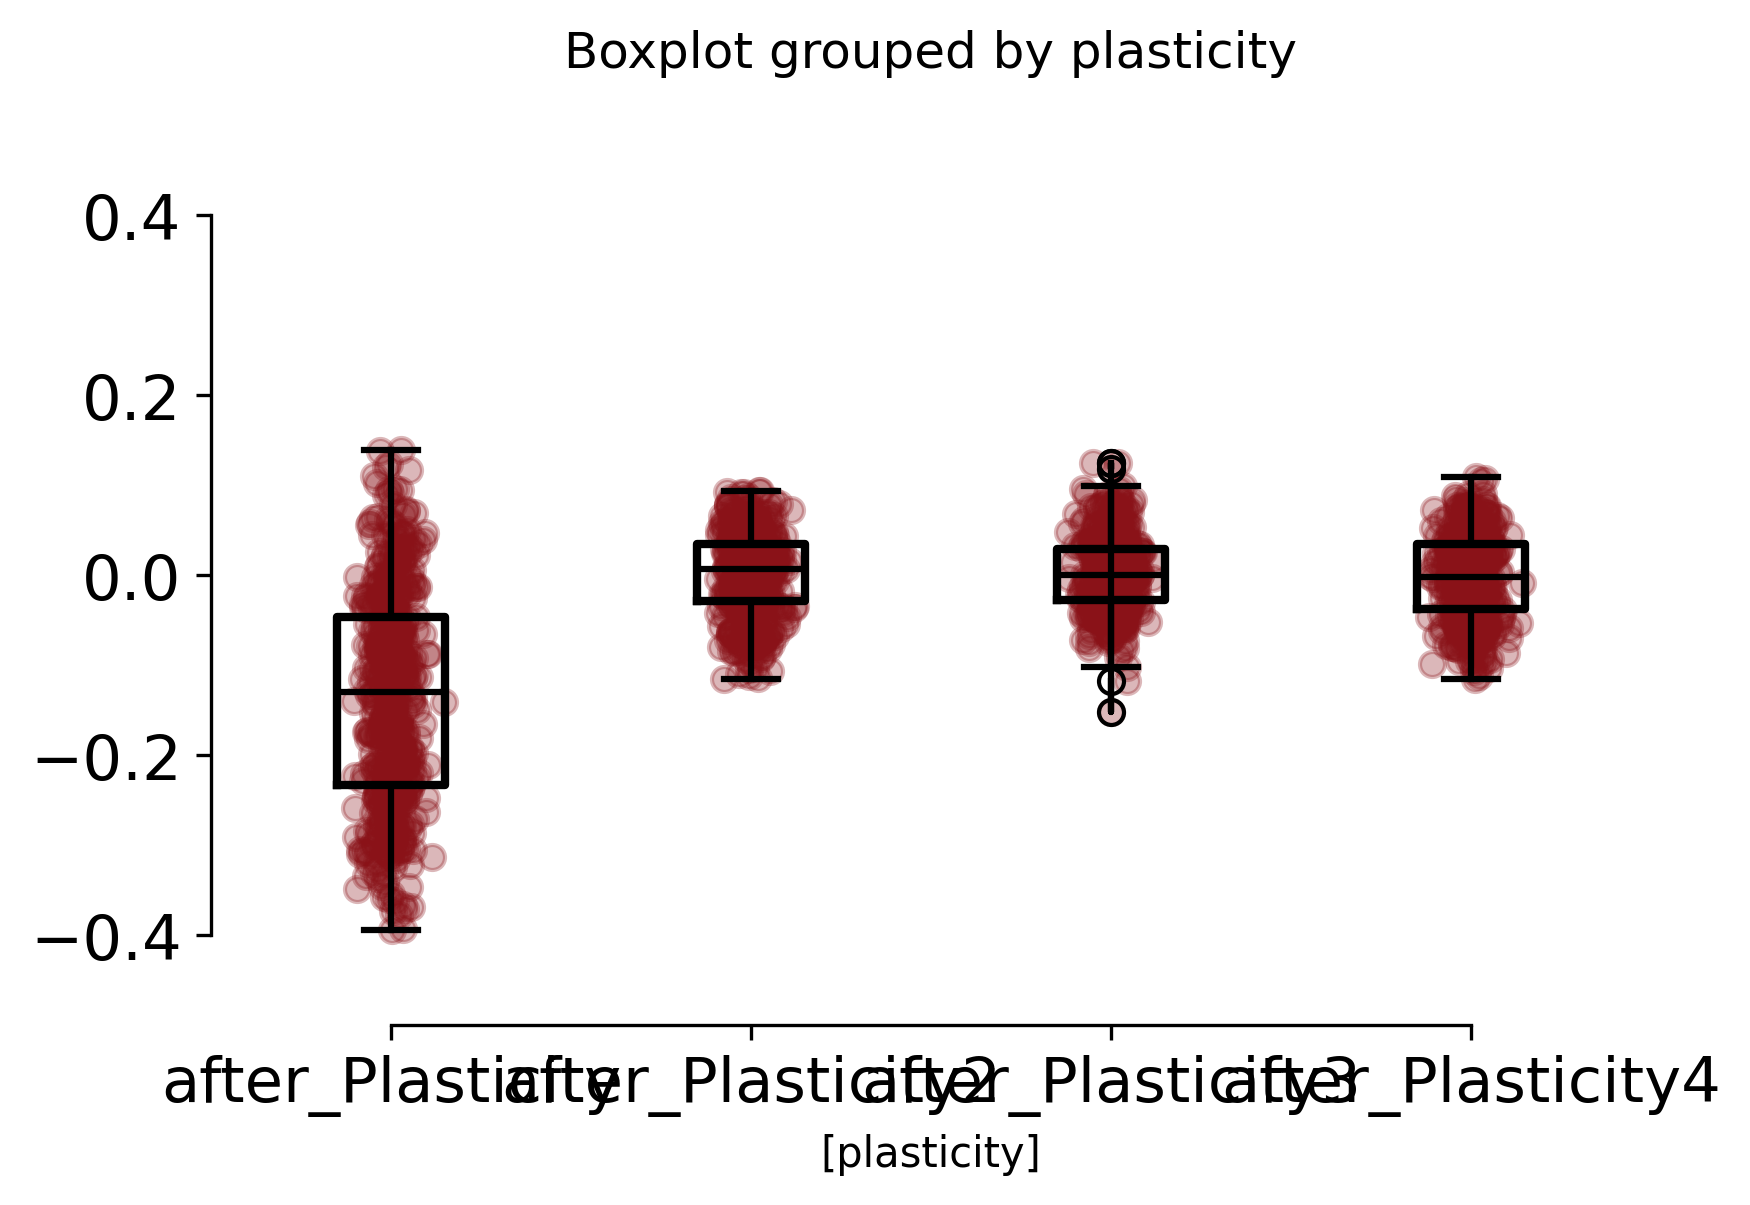

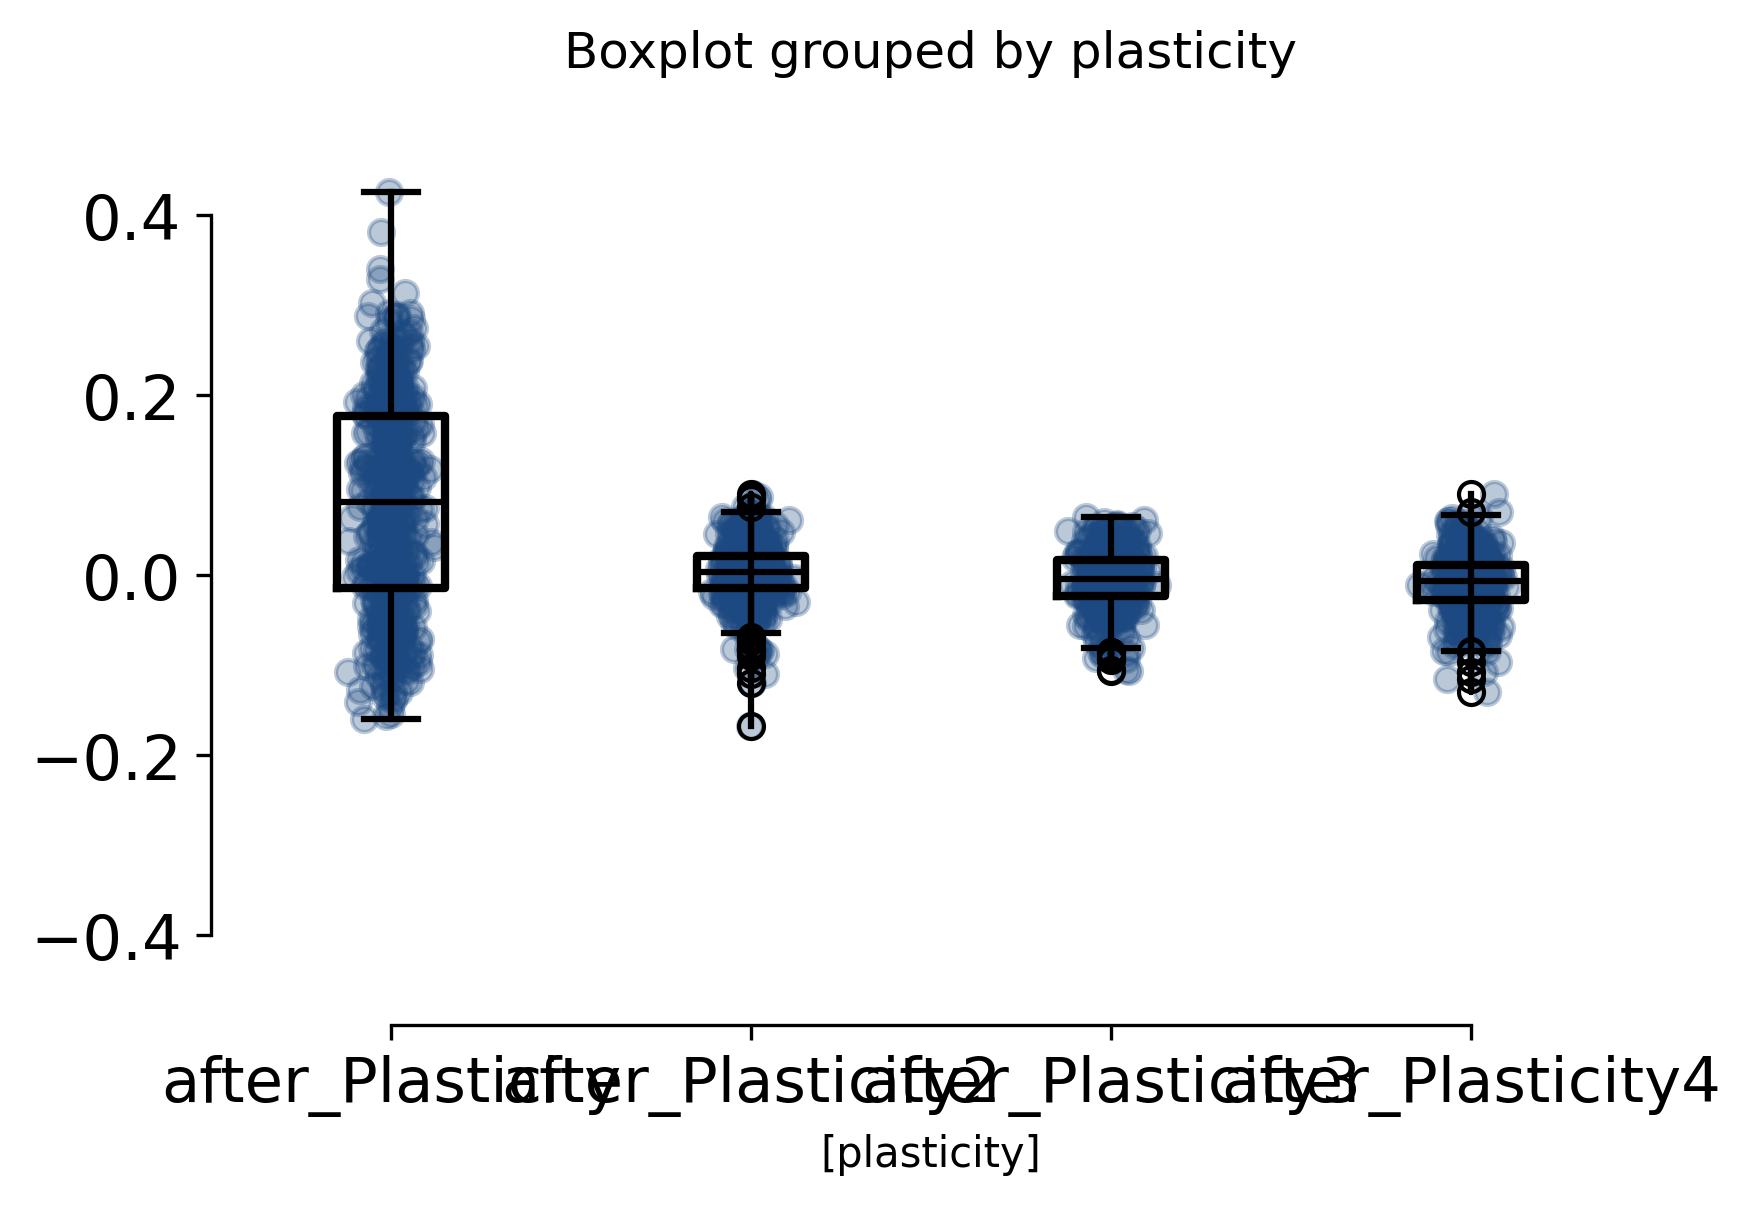

In [96]:
var = 'diff'
zebrin_range = ['negative','positive']
for zebrin in zebrin_range:
    for coupling in (['_Coupled']):#, '']):
        df_data = df_diff[(df_diff["coupling"]==coupling)&(df_diff["zebrin"]==zebrin)]
        Q1, Q3 = percentile(df_data[var],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]

        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        fig = plt.figure(dpi=300)
        bp = df_data2.boxplot(column=var, by=['plasticity'], grid=False, figsize=(8,7), widths=0.3, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca())  
        title(f'')#Firing frequency {plasticity}{coupling}')
        colors = dict(positive='#1c4981',negative='#8a1218')
        for j,plasticity in enumerate(range_after_plasticity):
            y = df_data2[(df_data2.plasticity==plasticity)].dropna()
            y = y['diff']
            x = np.random.normal(1+j, 0.04, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x, y, color=colors[zebrin], alpha=0.3)
    #     xticks(range(1,len(plasticity_range[0:2]*2)+1),plasticity_range[0:2]*2)
        plt.ylim(-0.5,0.5)
#         axhline(0)
#         axis('off')
        sns.despine(trim=True)
        plt.savefig(f'Difference_epoch{zebrin}.svg')
        plt.show()

# Figure 2 - Extra

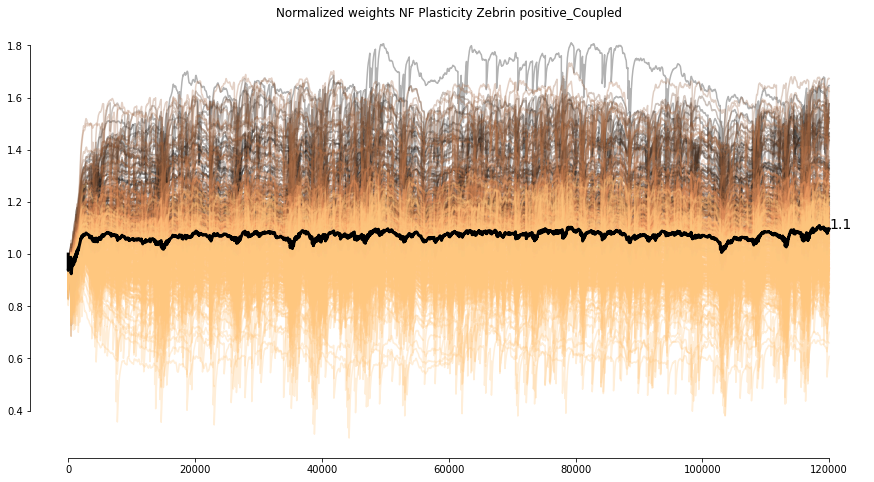

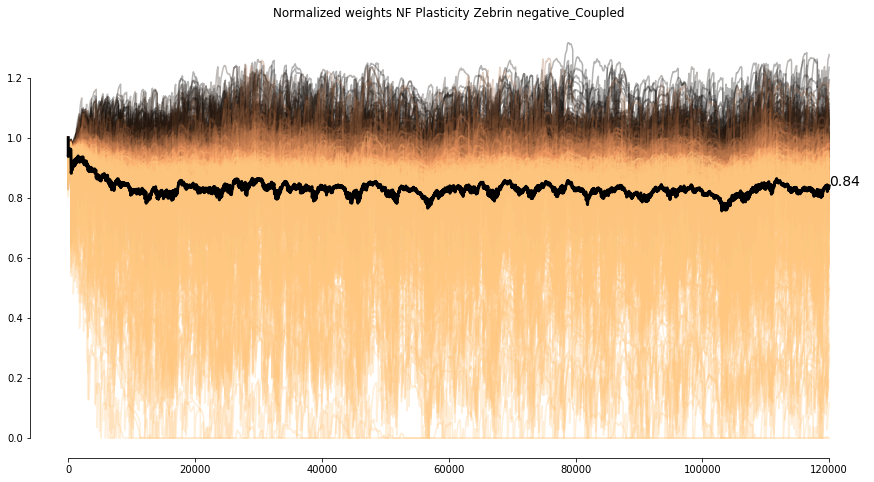

CPU times: user 10.4 s, sys: 10.1 s, total: 20.5 s
Wall time: 2min 56s


In [8]:
%%time
f0_name = {}
height = {}
y_loc = {}
f0_name_arr = []
for f0 in f0_range:
    step = 5
    if f0 >= 50: 
        step = 25
    if f0 >= 100: 
        step = 50
    lowcut = f0
    highcut = lowcut + step
    if f0 == 800:
        lowcut = 1
        highcut = f0 
    fname = f'F{lowcut}-{highcut} Hz'
    if f0 == 0:
        fname = f'NF'
    elif f0 == 1000:
        fname = '1-200,200-400,400-600,600-800 and 1-800'
    elif f0 == 1100:
        fname = 'Sine and original OU'
    elif f0 == 1200:
        fname = 'Sine and different filtered'
    elif f0 == 1300:
        fname = 'Sine added to OU'
    elif f0 == 1400:
        fname = 'Only sine different phases'
    elif f0 == 1500:
        fname = '2,10,50,100,200 Hz sines'
    f0_name_arr.append(fname)
    f0_name[f0] = fname
    height[f0] = highcut-lowcut
    y_loc[f0] = (highcut+lowcut)/2


cmap = plt.get_cmap('copper')
coupling = '_Coupled'
mean_dict = {}
for zebrin in zebrin_range:
    mean_dict[zebrin] = {}
    for f0 in f0_range[0:1]:
        mean_dict[zebrin][f0] = {}
        for plasticity in range_plasticity[0:1]:
            avg_arr = []
            mon_N_PC_output = output_load_run('mon_N_PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['new_weight']
            plt.figure(figsize=(15, 8))
            plt.title(f'Normalized weights {f0_name[f0]} {plasticity} Zebrin {zebrin}{coupling}')
            for pc_num in range(N_Cells_PC*N_Cells_PF):
                avg_arr.append(mon_N_PC_output[pc_num]/mon_N_PC_output[pc_num][0])
                plot(mon_N_PC_output[pc_num]/mon_N_PC_output[pc_num][0], color=cmap(pc_num),alpha=0.3)
            mean_arr = mean(avg_arr,axis=0)
            plot(mean_arr,lw=3,color='k')
            text(len(mean_arr),mean_arr[-1], f'{round(mean_arr[-1],2)}',fontsize=14)
            mean_dict[zebrin][f0][plasticity] = mean_arr[-1]
            sns.despine(trim=True)
            plt.show()